# Imports and Data

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import os
import matplotlib.pyplot as plt
import phonecalls as pc
import scipy.stats as stats
import scipy.interpolate as interpol
import time
import copy
import math
import pickle


plt.rcParams['figure.figsize'] = (20, 10)
markers = ['o', 'v', 's', 'P', '*', 'X', 'd', 'x', 'D', '2', '+']
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

with open('unfiltered.pkl', 'rb') as handle:
    unfiltered = pickle.load(handle)
handle.close()

with open('filtered.pkl', 'rb') as handle:
    filtered = pickle.load(handle)
handle.close()

with open('filterednc.pkl', 'rb') as handle:
    filterednc = pickle.load(handle)
handle.close()

import statsmodels.api as sm

globalt0 = dt.datetime.now()

# Edit main paper results

There is an inconsistency between the reported results and the results of the current version of the paper. Since lifetimes for each alter were limited to $\mathcal{T}$, whenever an alter reaches lifetime $\ell >= \mathcal{T}$, its lifetime is truncated to $\mathcal{T}$. This generates an over representation of alters with $\ell = \mathcal{T}$. The fix is simple: I will only consider alters with $\ell < \mathcal{T}$.

In [2]:
calls = {}
for c in ['uk', 'uk2', 'mit']:
    calls[c] = pc.limit_calls(unfiltered[c], 231)

## Fig 2

In [3]:
alldff = {}
for c in calls.keys():
    alldff[c] = pc.get_f(calls[c], 'all', 15, 67)
    
# with open('../itdata/mtl_all_lambda_alpha_fig2.pickle', 'rb') as handle:
#     alldff['it'] = pickle.load(handle)
#     handle.close()

In [4]:
lives = {}
for c in calls.keys():
    lives[c] = pc.lives_dictionary(calls[c])
    
# with open('../itdata/mtl_all_lives.pickle', 'rb') as handle:
#     lives['it'] = pickle.load(handle)['all']
#     handle.close()

In [5]:
limits = {}
limits[0] = (0, 66)
limits[1] = (67, 133)
limits[2] = (134, 199)

stablec = {}
for c in alldff.keys():
    stablec[c] = {}
    for i in limits.keys():
        stablec[c][i] = pc.get_avgfa(alldff[c], lives[c], limits[i][0], limits[i][1])

In [6]:
lines = {}
lines[0] = (1, 4)
lines[1] = (2, 8)
lines[2] = (2, 12)
dashed = {}

for c in stablec.keys():
    dashed[c] = {}
    print(f'======================={c}=====================')
    for l in stablec[c].keys():
        df = stablec[c][l].loc[(stablec[c][l].index >= lines[l][0]) & (stablec[c][l].index <= lines[l][1])]
        h = np.mean(df['f'])
        dashed[c][l] = ([lines[l][0], lines[l][1]], [h, h])
        print(f'\draw[dashed, {["charmander", "squirtle", "ekans"][int(l)]}, ultra thick] (axis cs: {lines[l][0]}, {h}) -- (axis cs: {lines[l][1]}, {h});')

=======================uk=====================
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.16332183718448368) -- (axis cs: 4, 0.16332183718448368);
\draw[dashed, squirtle, ultra thick] (axis cs: 2, 1.0787589590992346) -- (axis cs: 8, 1.0787589590992346);
\draw[dashed, ekans, ultra thick] (axis cs: 2, 1.2210919540662812) -- (axis cs: 12, 1.2210919540662812);
=======================uk2=====================
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.27846427023472986) -- (axis cs: 4, 0.27846427023472986);
\draw[dashed, squirtle, ultra thick] (axis cs: 2, 1.7314179718519138) -- (axis cs: 8, 1.7314179718519138);
\draw[dashed, ekans, ultra thick] (axis cs: 2, 1.849614652982647) -- (axis cs: 12, 1.849614652982647);
=======================mit=====================
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.2117075829484217) -- (axis cs: 4, 0.2117075829484217);
\draw[dashed, squirtle, ultra thick] (axis cs: 2, 1.648980133050039) -- (axis cs: 8, 1.648980133050039);

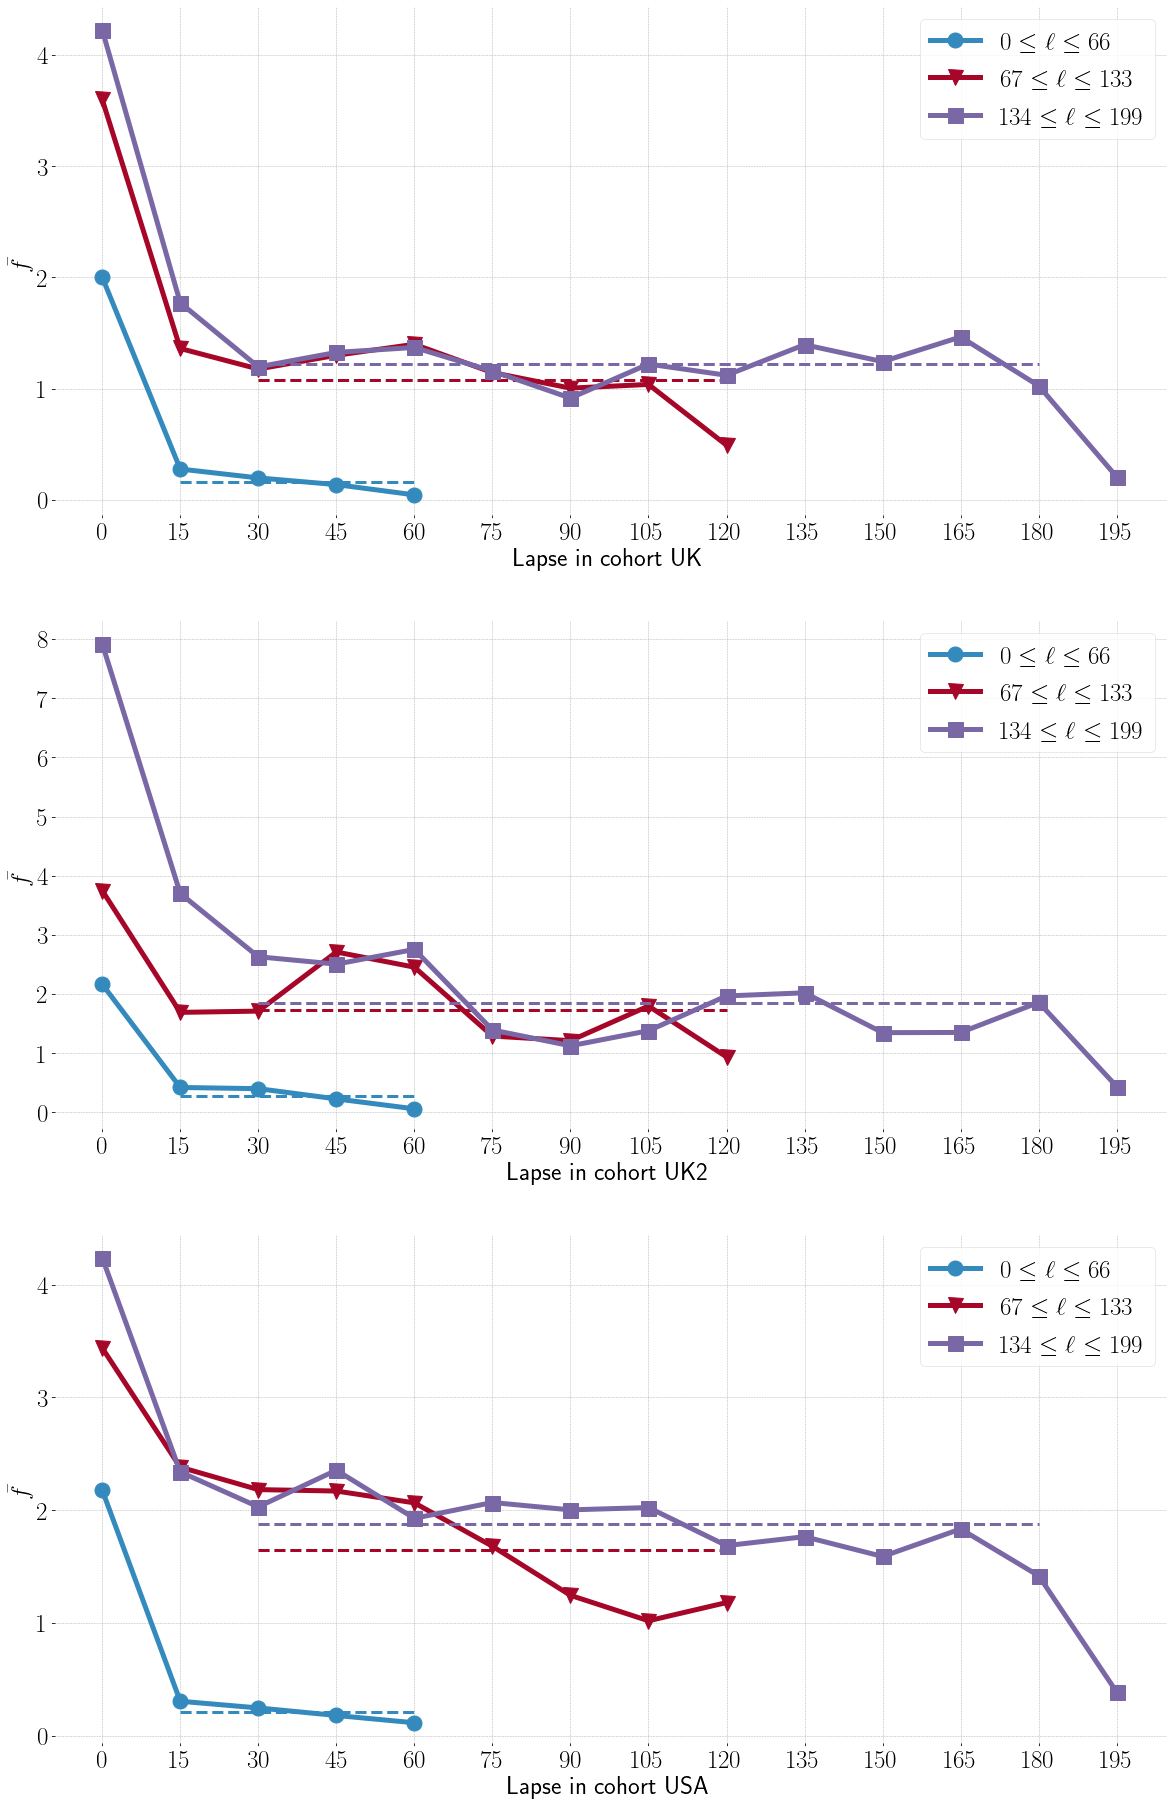

In [7]:
plt.figure(figsize=(20, 32))
p = 1
labels = [fr'${limits[i][0]} \leq \ell \leq {limits[i][1]}$' for i in range(3)]
labels.append(r'$\ell >= 199$')
cohorts = ['UK', 'UK2', 'USA', 'Italy']
for c in ['uk', 'uk2', 'mit']:
    plt.subplot(3,1,p)
    plt.xlabel(f"Lapse in cohort {cohorts[p - 1]}")
    plt.ylabel(r"$\bar{f}$")
    plt.xticks(range(0, 201, 15))
    for lamb in stablec[c].keys():
        l = int(lamb)
        plt.plot([15 * x for x in stablec[c][l].index], stablec[c][l]['f'], marker=markers[l], ls="-", lw=5, markersize=15, label=labels[l])
        plt.plot([15 * x for x in dashed[c][l][0]], dashed[c][l][1], marker="", ls="--", lw=3, c=colors[l])
    plt.legend()
    p += 1

In [8]:
# for c in stablec.keys():
#     tmp = pd.DataFrame()
#     for l in stablec[c].keys():
#         df = stablec[c][l]
#         df.columns = [f'l{int(l)}']
#         if len(tmp) == 0:
#             tmp = tmp.append(df)
#         else:
#             tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
#     tmp.index.rename('a', inplace=True)
#     tmp.fillna('nan', inplace=True)
#     tmp = tmp.loc[tmp.index < 13]
#     tmp.to_csv(f"../commpatterns/PNAS_paper/figs/fig2c_{c}.dat", header=True, sep="\t")

## fig 3

In [9]:
lives = {}
for c in calls.keys():
    lives[c] = pc.lives_dictionary(calls[c])
    
with open('../itdata/mtl_all_lives.pickle', 'rb') as handle:
    lives['it'] = pickle.load(handle)['all']
    handle.close()

In [10]:
tmp = {}
for c in calls.keys():
    tmp[c] = pc.get_f(calls[c], 'all', 30, 10)
    
with open('../itdata/mtl_all_lambda_alpha_fig3.pickle', 'rb') as handle:
    tmp['it'] = pickle.load(handle)
    handle.close()
    
alldff2 = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    alldff2[c] = {}
    nump = 0
    nump2 = 0
    for ego in tmp[c].keys():
        alldff2[c][ego] = {}
        for alter in tmp[c][ego].keys():
            ell = lives[c][ego][alter]['ell']
            nump += 1
            if ell < 200:
                alldff2[c][ego][alter] = tmp[c][ego][alter]
                nump2 += 1
    print(c, nump, nump2)

uk 4595 3969
uk2 1709 1526
it 16984 16803
mit 5999 5128


In [11]:
alldff2['all'] = {}
for c in ['uk', 'mit', 'it']:
    alldff2['all'].update(alldff2[c])
    
len(alldff2['all']) == len(alldff2['uk']) + len(alldff2['mit']) + len(alldff2['it'])

True

In [12]:
survall = pc.get_survival(alldff2['all'])

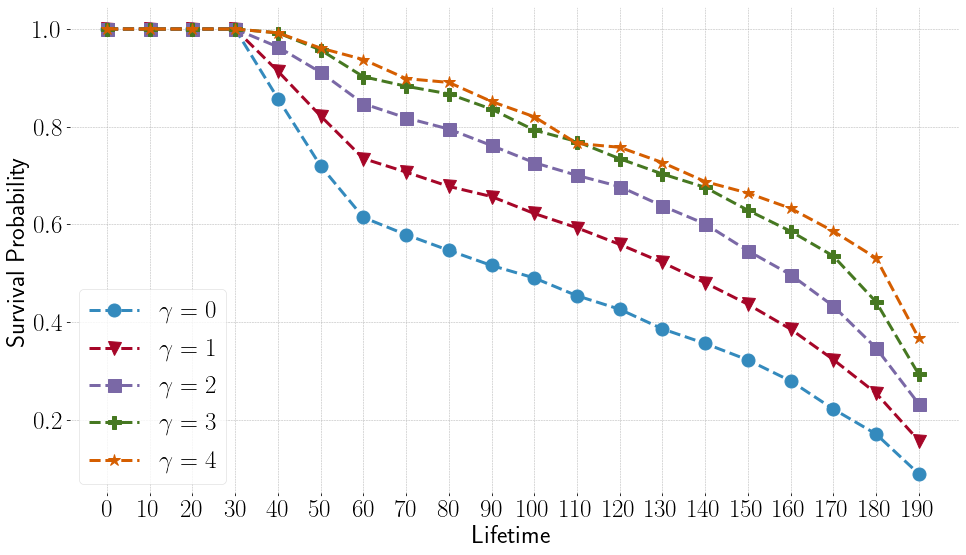

In [13]:
plt.figure(figsize=(16,9))
plt.xlabel(f"Lifetime ")
plt.ylabel("Survival Probability")
plt.xticks(range(0, 200, 10))
df = survall
for gamma in range(5):
    plt.plot([10 * x for x in df[gamma].index], df[gamma][0], marker=markers[gamma], markersize=13, ls="--", lw=3, label=fr'$\gamma = {gamma}$')
plt.legend()

In [14]:
# tmp = pd.DataFrame({'lc': list(survall[0].index)})
# for s in range(5):
#     df = survall[s]
#     tmp[f'p{int(s)}'] = df[0]
# tmp.to_csv(f'../commpatterns/PNAS_paper/figs/allsurvival.dat', header=True, index=False, sep="\t")

## Fig 4

In [15]:
dffUM = {}
for c in ['uk', 'mit']:
    dffUM.update(alldff2[c])
    
surv_cont = pc.get_survival(dffUM)

In [16]:
# tmp = pd.DataFrame()
# for s in range(6):
#     df = surv_cont[s].reset_index()
#     df.columns = ['lc', 'p']
#     df['lc'] *= 10
#     df['f'] = 2**s
#     ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
#     tmp = tmp.append(ttmmpp).reset_index(drop=True)
# tmp.to_csv(f"../commpatterns/PNAS_paper/figs/contour.dat", header=False, index=False, sep="\t")

In [17]:
points_it = pc.get_survival(alldff2['it'], unbinned=True)

# tmp = pd.DataFrame()
# for s in points_it.keys():
#     if s <= 2**5 + 1:
#         df = points_it[s].reset_index()
#         df.columns = ['lc', 'p']
#         df['lc'] *= 10
#         df['f'] = s
#         ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
#         tmp = tmp.append(ttmmpp).reset_index(drop=True)
# sub = [(i/4, (i + 1)/4) for i in range(4)]
# p = 0
# for s in sub:
#     df = tmp.loc[(tmp['z'] > s[0]) & (tmp['z'] <= s[1])]
#     df = df.drop(columns='z')
#     df.to_csv(f'../commpatterns/PNAS_paper/figs/points{p}.dat', header=False, index=False, sep="\t")
#     print(s)
#     p += 1

# SI (revised)

I need to produce a version of the calls dataframe that I will be able to modify tfor the different variants included in the SI.

## Different values of $\Delta a$.

In [18]:
limits = {}
limits[0] = (0, 66)
limits[1] = (67, 133)
limits[2] = (134, 199)

In [19]:
supB = {}
for c in calls.keys():
    supB[c] = {}
    for Da in [7, 15, 30, 45]:
        supB[c][Da] = {}
        dff = pc.get_f(calls[c], 'all', Da, 67)
        for i in limits.keys():
            supB[c][Da][i] = pc.get_avgfa(dff, lives[c], limits[i][0], limits[i][1])

And Italy is also required

In [20]:
with open('../itdata/mtl_supB.pickle', 'rb') as handle:
    tmp = pickle.load(handle)
    handle.close()
    
supB['it'] = {}    
for Da in tmp.keys():
    supB['it'][Da] = {}
    for i in limits.keys():
        supB['it'][Da][i] = pc.get_avgfa(tmp[Da], lives['it'], limits[i][0], limits[i][1])

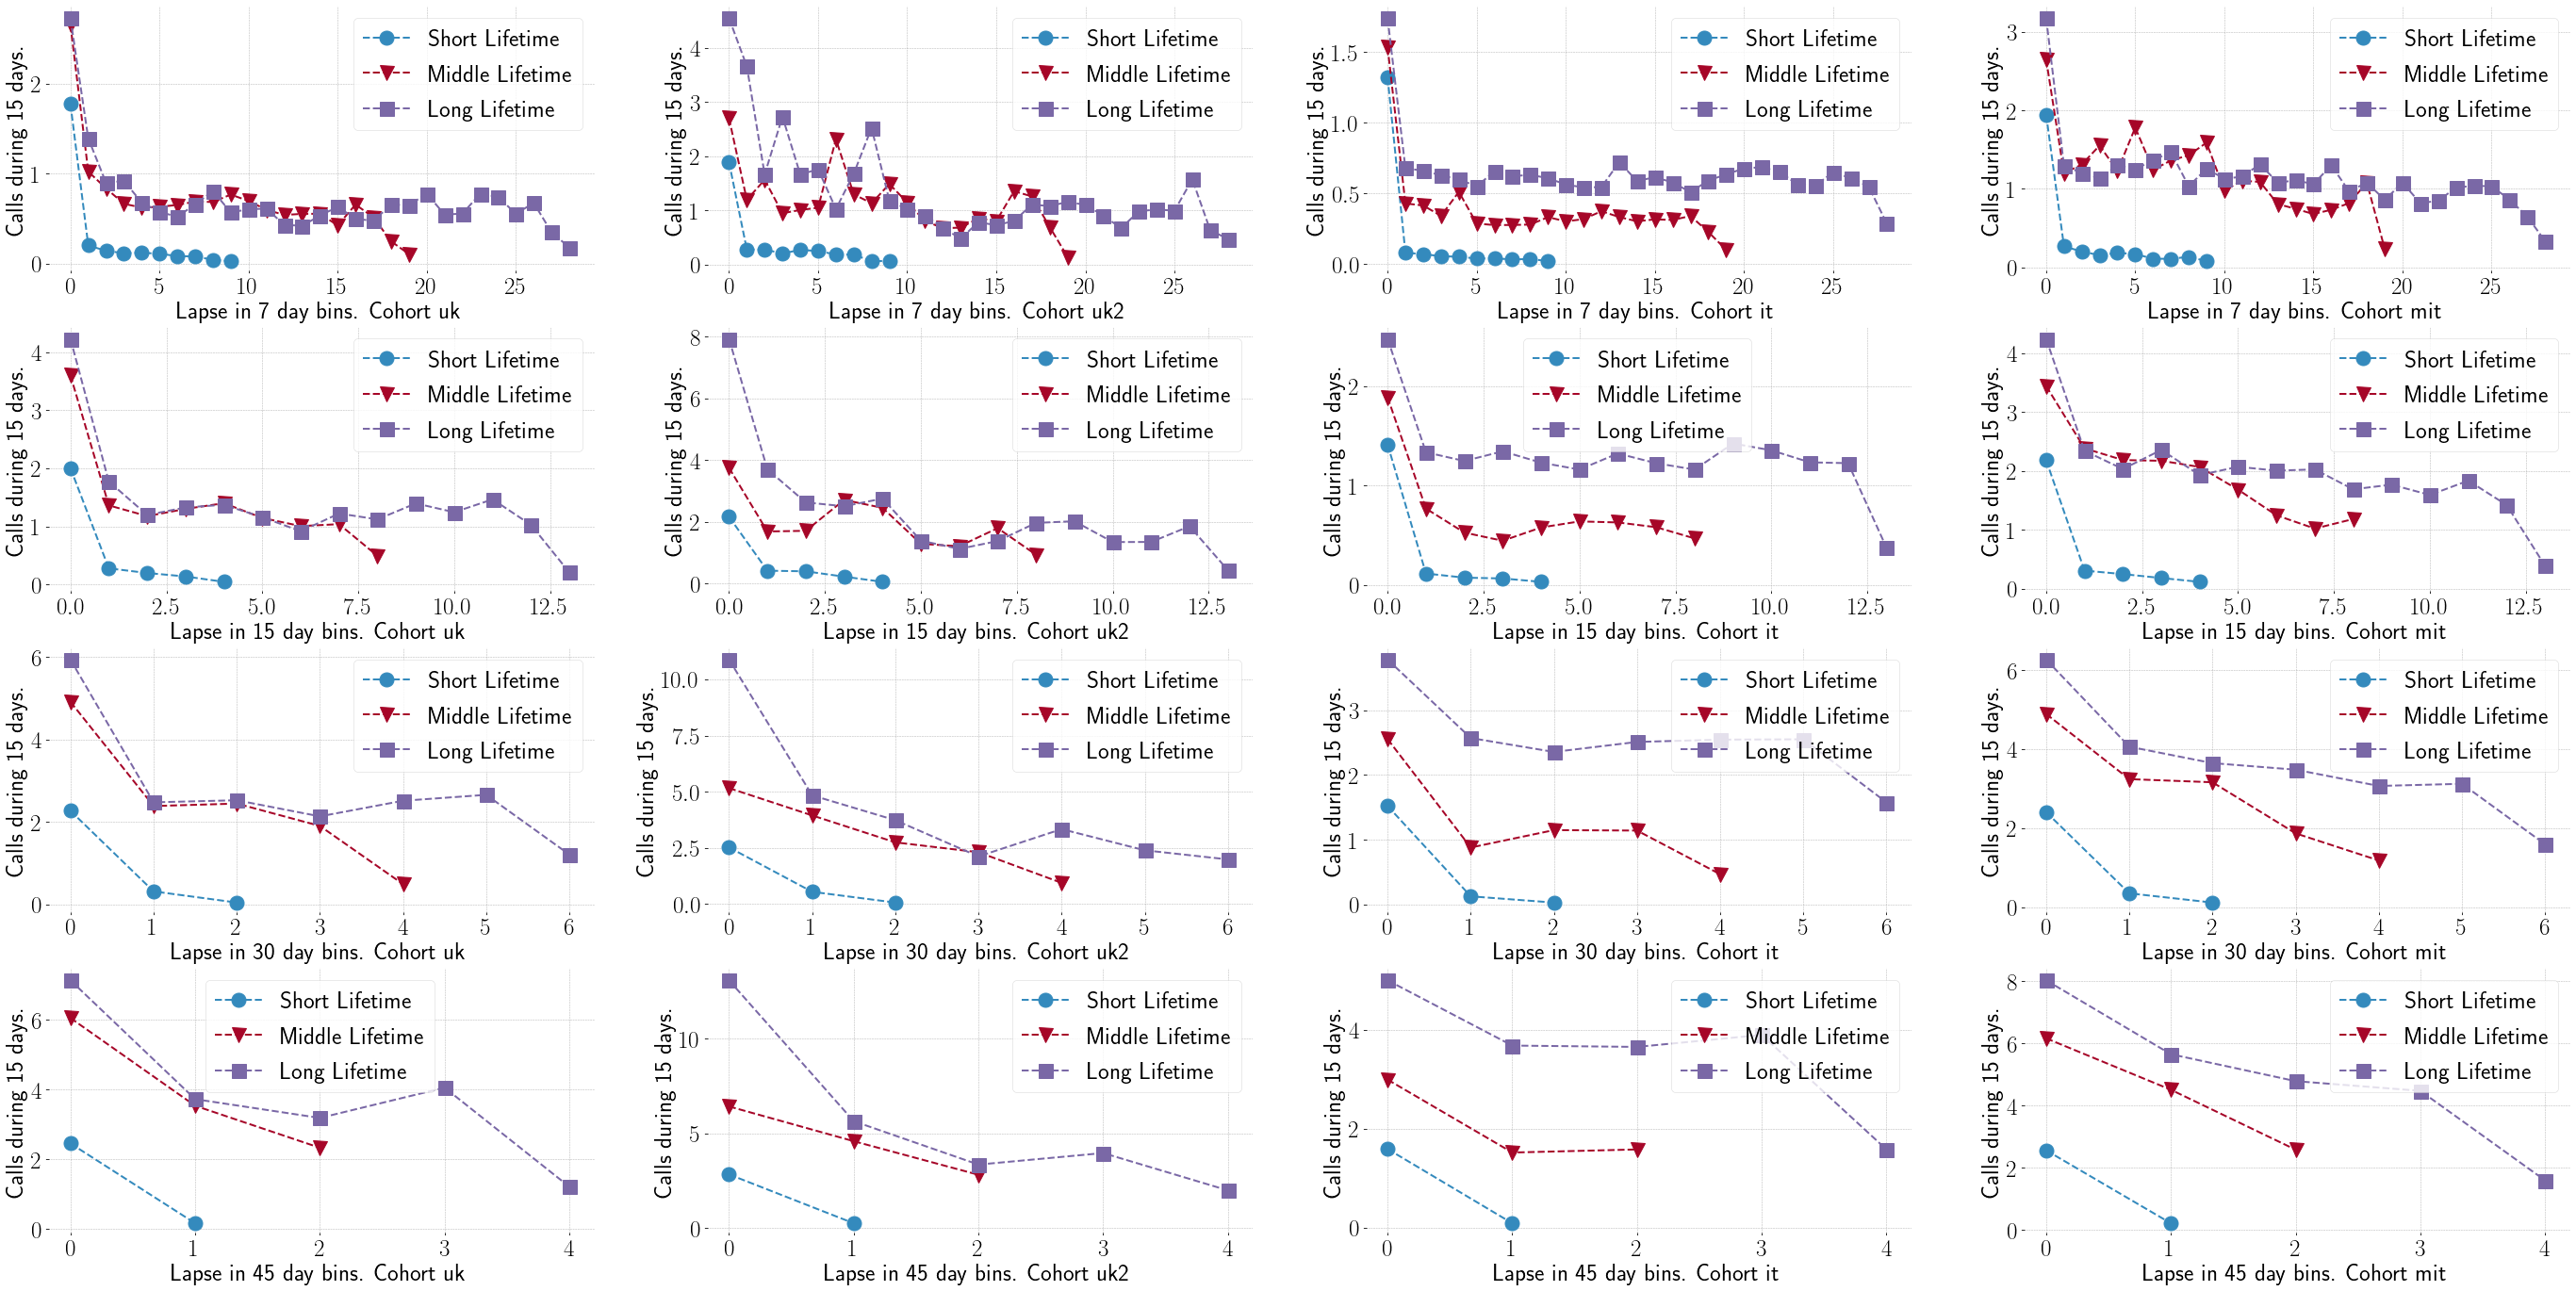

In [21]:
plt.figure(figsize=(48, 24))
labels = ['Short Lifetime', 'Middle Lifetime', 'Long Lifetime']
p = 1
for Da in supB['uk'].keys():
    for c in ['uk', 'uk2', 'it', 'mit']:
        plt.subplot(4,4,p)
        plt.xlabel(f"Lapse in {Da} day bins. Cohort {c}")
        plt.ylabel(fr"Calls during 15 days.")
        for l in supB[c][Da].keys():
            plt.plot(supB[c][Da][int(l)].index, supB[c][Da][l]['f'], marker=markers[int(l)], markersize=15, ls="--", label=labels[int(l)])
        plt.legend()
        p += 1

In [22]:
lines = {}
lines[7] = {}
for lamb in range(3):
    lines[7][lamb] = ([1,3,3][lamb], [9, 15, 27][lamb])
lines[15] = {}
for lamb in range(3):
    lines[15][lamb] = (1, [4,8,12][lamb])
lines[30] = {}
for lamb in range(3):
    lines[30][lamb] = (1, [2,3,5][lamb])
lines[45] = {}
for lamb in range(3):
    lines[45][lamb] = (1, [1,2,3][lamb])

In [23]:
for c in ['uk', 'uk2', 'it', 'mit']:
    print(f'======================={c}=====================')
    for Da in supB[c].keys():
        print(f'===={Da}====')
        for lamb in supB[c][Da].keys():
            df = supB[c][Da][lamb].loc[(supB[c][Da][lamb].index >= lines[Da][lamb][0]) & (supB[c][Da][lamb].index <= lines[Da][lamb][1])]
            h = np.mean(df['f'])
            print(f'\draw[dashed, {["charmander", "squirtle", "ekans"][int(lamb)]}, ultra thick] (axis cs: {lines[Da][lamb][0]}, {h}) -- (axis cs: {lines[Da][lamb][1]}, {h});')

=======================uk=====================
====7====
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.10511518741291692) -- (axis cs: 9, 0.10511518741291692);
\draw[dashed, squirtle, ultra thick] (axis cs: 3, 0.6227129645854) -- (axis cs: 15, 0.6227129645854);
\draw[dashed, ekans, ultra thick] (axis cs: 3, 0.6096801302664746) -- (axis cs: 27, 0.6096801302664746);
====15====
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.16332183718448368) -- (axis cs: 4, 0.16332183718448368);
\draw[dashed, squirtle, ultra thick] (axis cs: 1, 1.114013861504313) -- (axis cs: 8, 1.114013861504313);
\draw[dashed, ekans, ultra thick] (axis cs: 1, 1.2669866362864932) -- (axis cs: 12, 1.2669866362864932);
====30====
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.1796337461914624) -- (axis cs: 2, 0.1796337461914624);
\draw[dashed, squirtle, ultra thick] (axis cs: 1, 2.2454206322008274) -- (axis cs: 3, 2.2454206322008274);
\draw[dashed, ekans, ultra thick] (axis cs: 1, 2.4627543512499406)

In [24]:
# for c in supB.keys():
#     tmp = pd.DataFrame(index=list(range(29)))
#     for Da in supB[c].keys():
#         for lamb in supB[c][Da].keys():
#             df = supB[c][Da][lamb]
#             if (lamb == 2) and (Da < 30):
#                 df = df.loc[df.index < list(df.index)[-1]] # To crop the last part of the longer lifetime series
#             df.columns = [f'Da{Da}l{int(lamb)}']
#             tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
#         tmp.index.rename('a', inplace=True)
#         tmp.fillna('nan', inplace=True)
#         tmp.to_csv(f"../commpatterns/PNAS_paper/SI/figs/SIb_{c}.dat", header=True, sep="\t")

## Variations on each lifetime group

In [25]:
limits = {}
limits['s0'] = (0, 66)
limits['s1'] = (0, 40)
limits['s2'] = (0, 50)
limits['s3'] = (0, 70)

limits['m0'] = (67, 133)
limits['m1'] = (67, 100)
limits['m2'] = (67, 115)
limits['m3'] = (67, 150)

limits['l0'] = (134, 199)
limits['l1'] = (134, 210)
limits['l2'] = (134, 220)
limits['l3'] = (134, 220)

In [26]:
supC = {}
for c in ['uk', 'uk2', 'mit']:
    supC[c] = {}
    for lf in limits.keys():
        supC[c][lf] = pc.get_avgfa(alldff[c], lives[c], limits[lf][0], limits[lf][1])

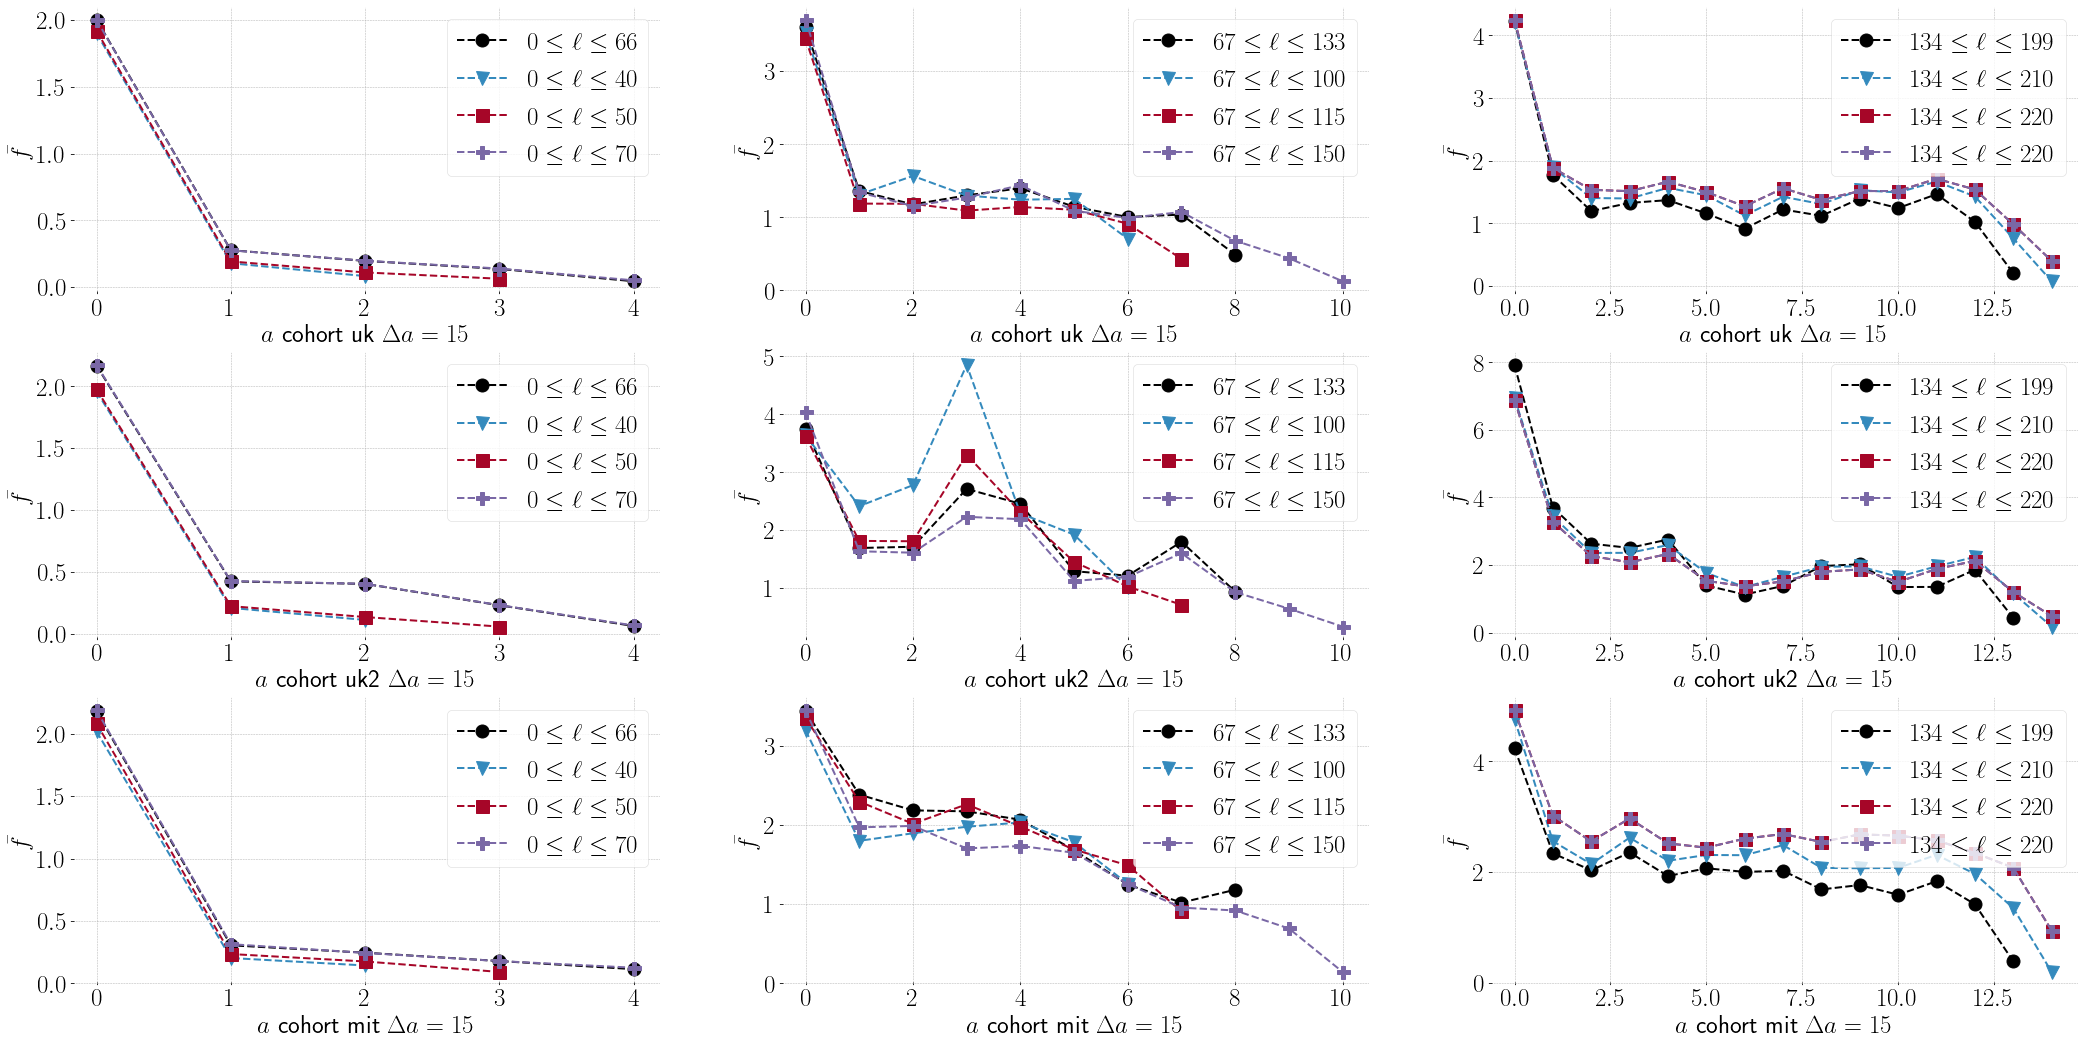

In [27]:
plt.figure(figsize=(36, 18))
p = 1
for c in supC.keys():
    for lf in ['s', 'm', 'l']:
        plt.subplot(3,3,p)
        plt.xlabel(fr"$a$ cohort {c} $\Delta a = 15$")
        plt.ylabel(r"$\bar{f}$")
        for i in range(4):
            key = lf + str(i)
            if i == 0:
                plt.plot(supC[c][key].index, supC[c][key]['f'], marker=markers[i], markersize=13, ls="--", lw=2, color="black", label=fr"${limits[key][0]} \leq \ell \leq {limits[key][1]}$")
            else:
                plt.plot(supC[c][key].index, supC[c][key]['f'], marker=markers[i], markersize=13, ls="--", lw=2, label=fr"${limits[key][0]} \leq \ell \leq {limits[key][1]}$")
        plt.legend()
        p += 1

In [28]:
# for c in supC.keys():
#     tmp = pd.DataFrame(index=list(range(14)))
#     for series in supC[c].keys():
#         data = supC[c][series].copy(deep=True)
#         data.columns = [f'{series}']
#         tmp = tmp.merge(data, left_index=True, right_index=True, how='outer')
#     tmp = tmp.fillna('nan')
#     tmp.index.rename('a', inplace=True)
#     tmp = tmp.loc[tmp.index < 13]
#     tmp.to_csv(f"../commpatterns/PNAS_paper/SI/figs/SIc_{c}.dat", header=True, sep="\t")

In [29]:
supC.keys()

dict_keys(['uk', 'uk2', 'mit'])

## Distribution of $g$

In [146]:
t0 = dt.datetime.now()
supD = {}
for c in ['uk', 'uk2', 'mit']:
    df = calls[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    lifetime = df.groupby('ea')[['aclock']].max()
    lifetime = lifetime.loc[lifetime['aclock'] <= 199]
    df = df[df['ea'].isin(lifetime.index)]
    g = df.groupby('ea')[['time']].count()
    Hall = pc.histogram(g['time'], 30)
    df2 = df.loc[(df['aclock'] >= 30) & (df['aclock'] <= 60)]
    g = df2.groupby('ea')[['time']].count()
    H = pc.histogram(g['time'], 30)
    supD[c] = (Hall, H)
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:00.209013


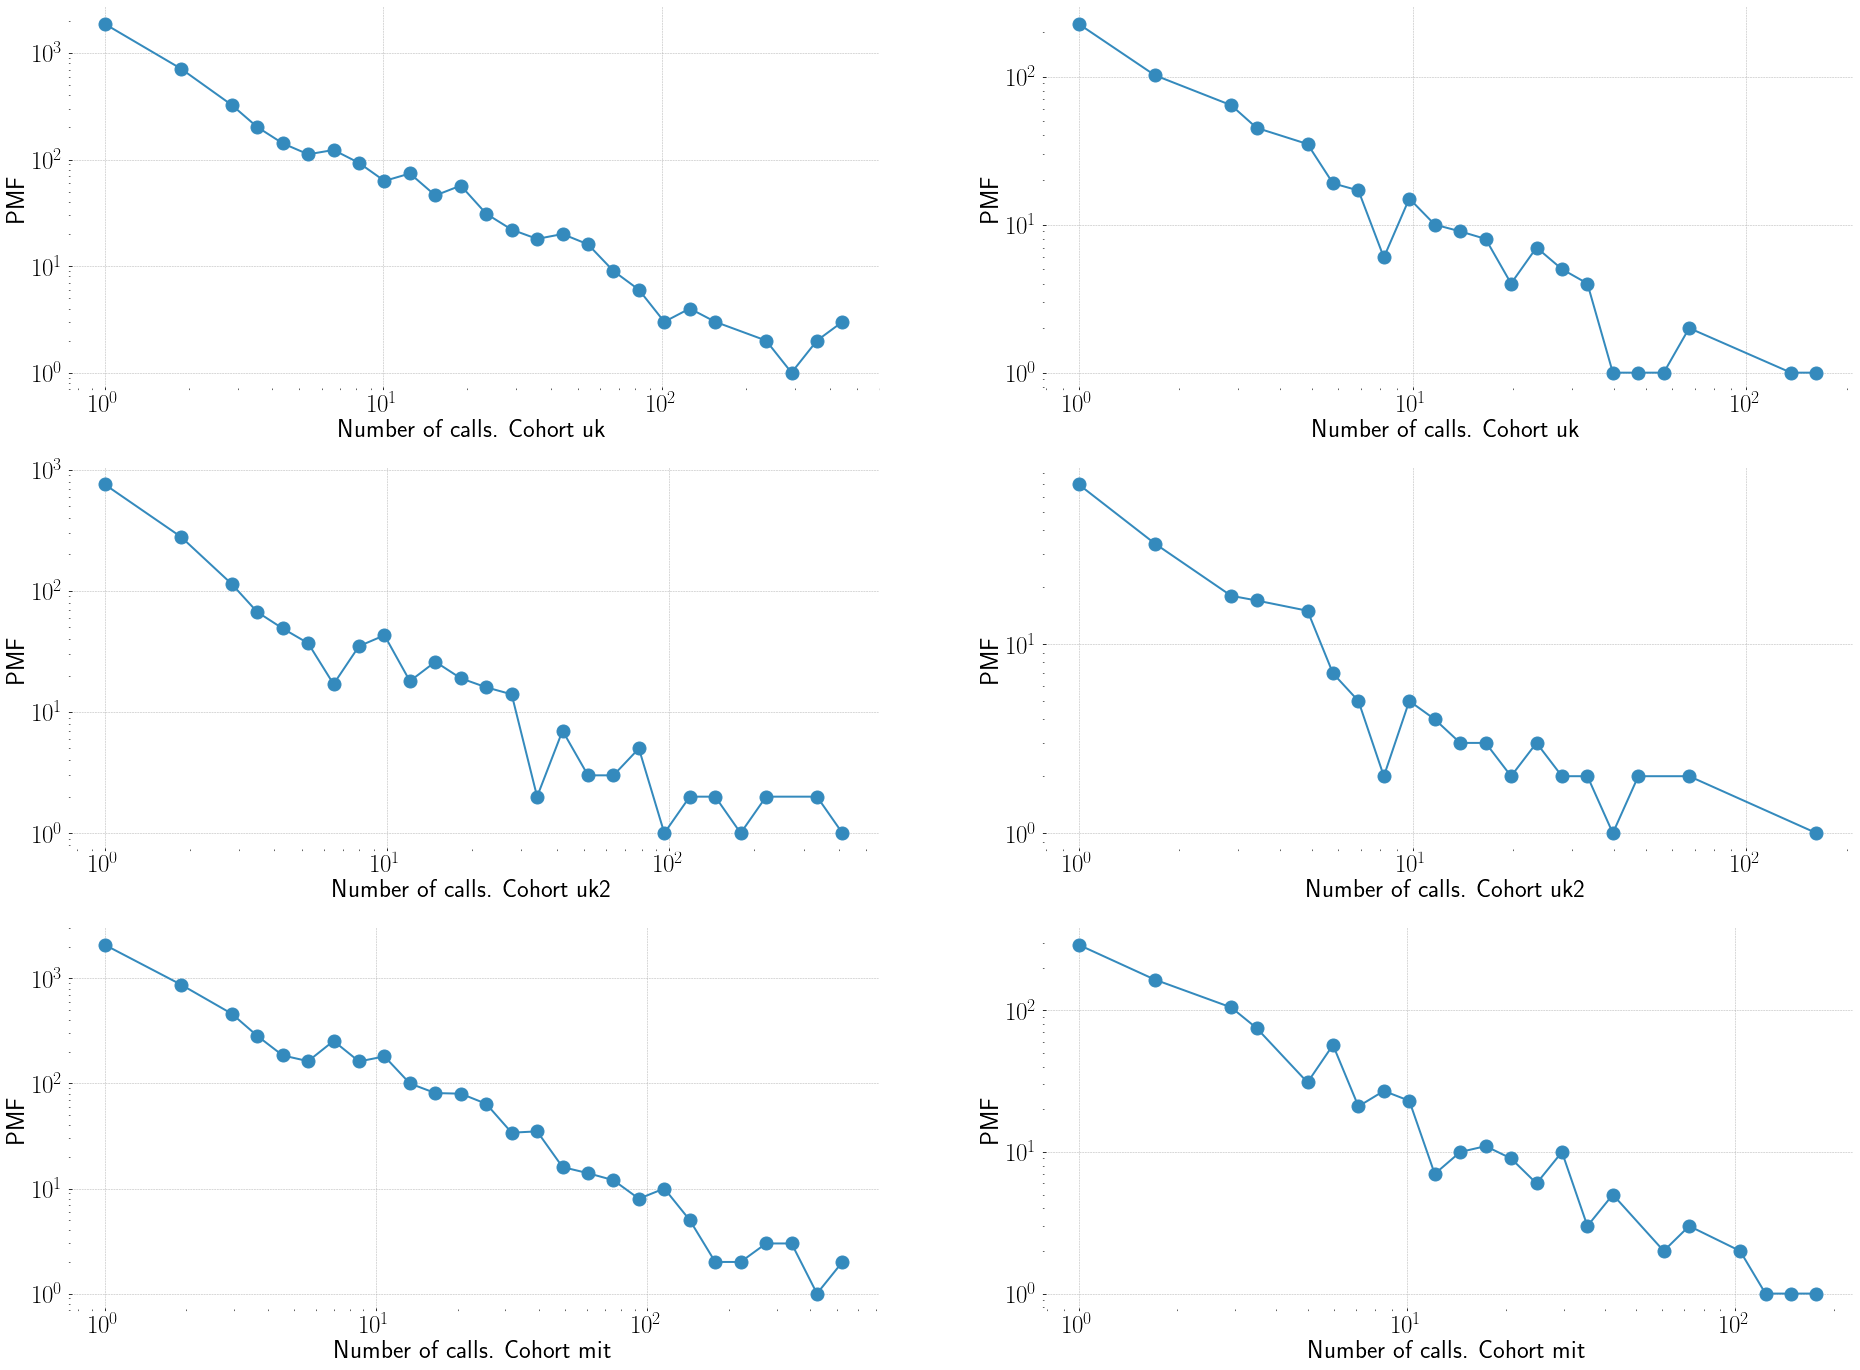

In [147]:
plt.figure(figsize=(32, 24))
p = 1
for c in supD.keys():
    for i in range(2):
        plt.subplot(3,2,p)
        plt.xlabel(f"Number of calls. Cohort {c}")
        plt.ylabel(f"PMF")
        plt.loglog()
        df = supD[c][i]
        plt.plot(df['label'], df['h'], "o-", markersize=13)
        p += 1

In [148]:
tmp = pd.DataFrame(index=list(range(30)))
for c in supD.keys():
    for col in range(2):
        df = supD[c][col].sort_index()
        x = []
        y = []
        df2 = df.reset_index(drop=True)
        for i in range(30):
            if i in df2.index:
                x.append(df2.at[i, 'label'])
                y.append(df2.at[i, 'pmf'])
            else:
                x.append('nan')
                y.append('nan')
        tmp[f'{c+["a", "s"][col]}_x'] = x
        tmp[f'{c+["a", "S"][col]}_y'] = y
tmp.to_csv(f"../commpatterns/PNAS_paper/SI/figs/SId.dat", header=True, index=False, sep="\t")

## Different values for $a_o$ and $a_f$: fig 3

In [96]:
for c in calls.keys():
    print(max(calls[c]['aclock']))

231
231
231


In [97]:
def get_survival(callsdf, maxT, ao, af, lives, unbinned=False):
    tmp = {}
    df = callsdf.loc[(callsdf['aclock'] >= ao) & (callsdf['aclock'] <= af)]
    for ego in df['ego'].unique():
        df1 = df.loc[df['ego'] == ego]
        for alter in df1['alter'].unique():
            ell = lives[ego][alter]['ell']
            if ell <= maxT:
                df2 = df1.loc[df1['alter'] == alter]
                if unbinned:
                    g = len(df2)
                else:
                    g = int(np.log2(len(df2)))
                tmp[g] = tmp.get(g, {})
                lamb = ell // 10
                tmp[g][lamb] = tmp[g].get(lamb, 0) + 1
    tmp2 = {}
    for g in sorted(tmp.keys()):
        df = pd.DataFrame.from_dict(tmp[g], orient='index').sort_index()
        tmp2[g] = {}
        df['p'] = df[0].div(sum(df[0]))
        for lc in range(max(df.index) + 1):
            df2 = df.loc[df.index >= lc]
            tmp2[g][lc] = round(sum(df2['p']), 6)
        tmp2[g] = pd.DataFrame.from_dict(tmp2[g], orient='index').sort_index()
    return tmp2

In [103]:
lives = {}
lives['all'] = {}
for c in calls.keys():
    lives[c] = pc.lives_dictionary(calls[c])
    if (c == 'uk') or (c == 'mit'):
        lives['all'].update(lives[c])

In [114]:
calls['all'] = calls['uk'].copy(deep=True)
calls['all'] = calls['all'].append(calls['mit'])

for c in calls.keys():
    df = calls[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    ncalls = df.groupby('ea')[['time']].count()
    ncalls = ncalls.loc[ncalls['time'] >= 3]
    df = df[df['ea'].isin(ncalls.index)]

In [116]:
len(lives['all'].keys()) == len(lives['uk'].keys()) + len(lives['mit'].keys())

True

In [115]:
len(calls['all']) == len(calls['uk']) + len(calls['mit'])

True

In [107]:
limitsa = [(0, 30), (15, 45), (30, 60), (45, 75)]

In [117]:
supE = {}
for i in range(len(limitsa)):
    supE[i] = get_survival(calls['all'], 199, limitsa[i][0], limitsa[i][1], lives['all'])

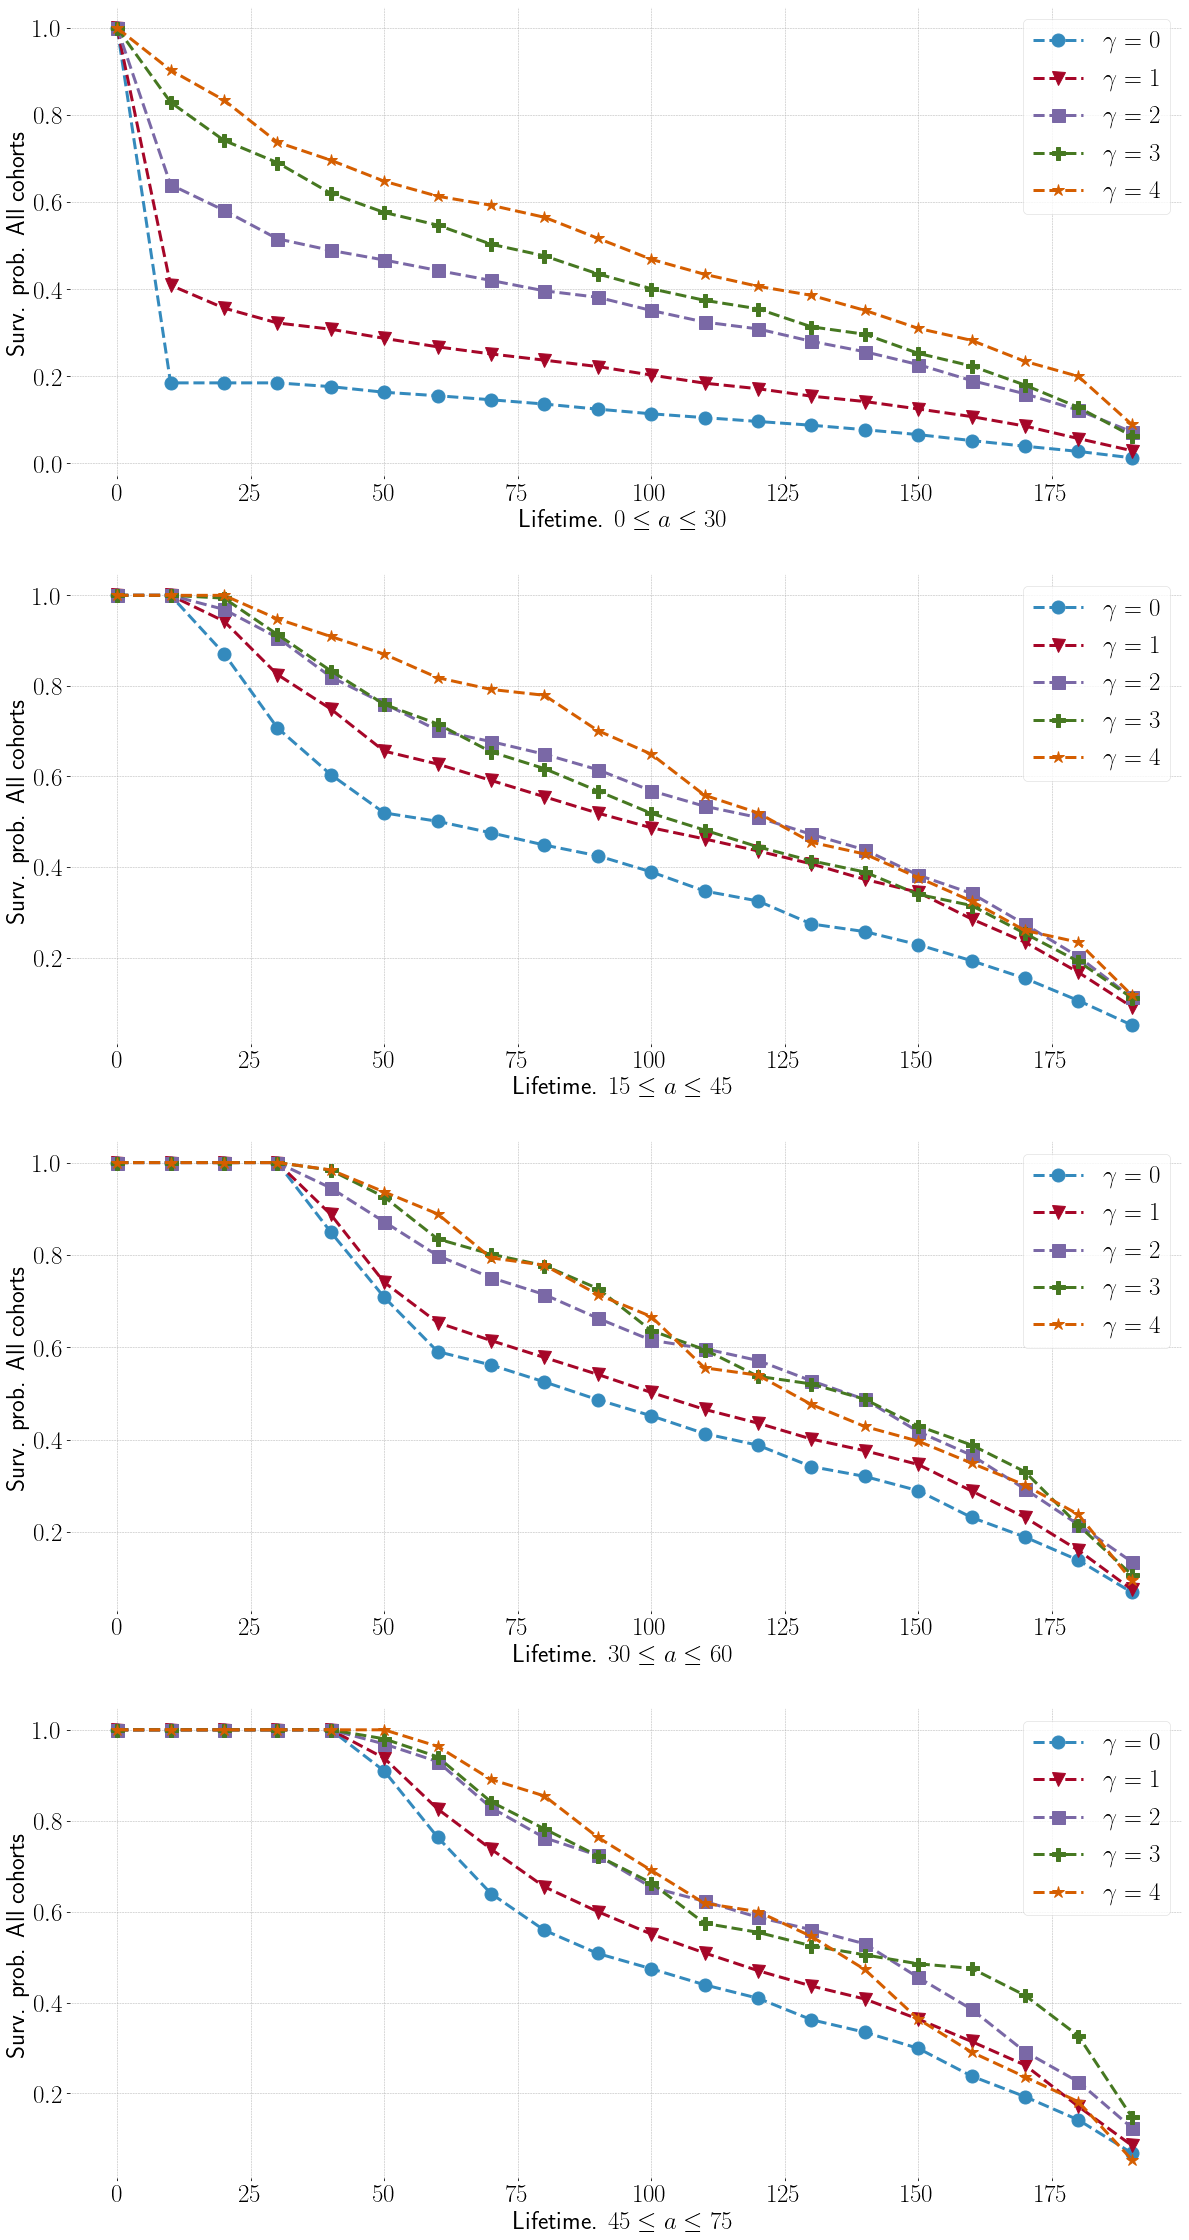

In [118]:
plt.figure(figsize=(20, 40))
p = 1
for lima in supE.keys():
    plt.subplot(4, 1, p)
    plt.xlabel(fr"Lifetime. ${limitsa[lima][0]} \leq a \leq {limitsa[lima][1]}$")
    plt.ylabel(f"Surv. prob. All cohorts")
    for i in range(5):
        plt.plot([x * 10 for x in supE[lima][i].index], supE[lima][i][0], marker=markers[i], markersize=13, ls="--", lw=3, label=fr'$\gamma = {i}$')
    plt.legend()
    p+=1

Another way to do this. Since I will need the information from Italy.

In [132]:
tmp = {}
tmp['all'] = {}
for c in ['uk', 'mit']:
    tmp[c] = pc.get_f(calls[c], 'all', 15, 10)
    tmp['all'].update(tmp[c])

dffa15 = {}
for c in tmp.keys():
    dffa15[c] = {}
    for ego in tmp[c].keys():
        dffa15[c][ego] = {}
        for alter in tmp[c][ego].keys():
            if lives[c][ego][alter]['ell'] < 199:
                dffa15[c][ego][alter] = tmp[c][ego][alter]

In [139]:
alphas = [(i, i + 1) for i in range(5)]
supE2 = {}
for i in range(len(alphas)):
    supE2[i] = pc.get_survival(dffa15['all'], alphafixed=alphas[i])

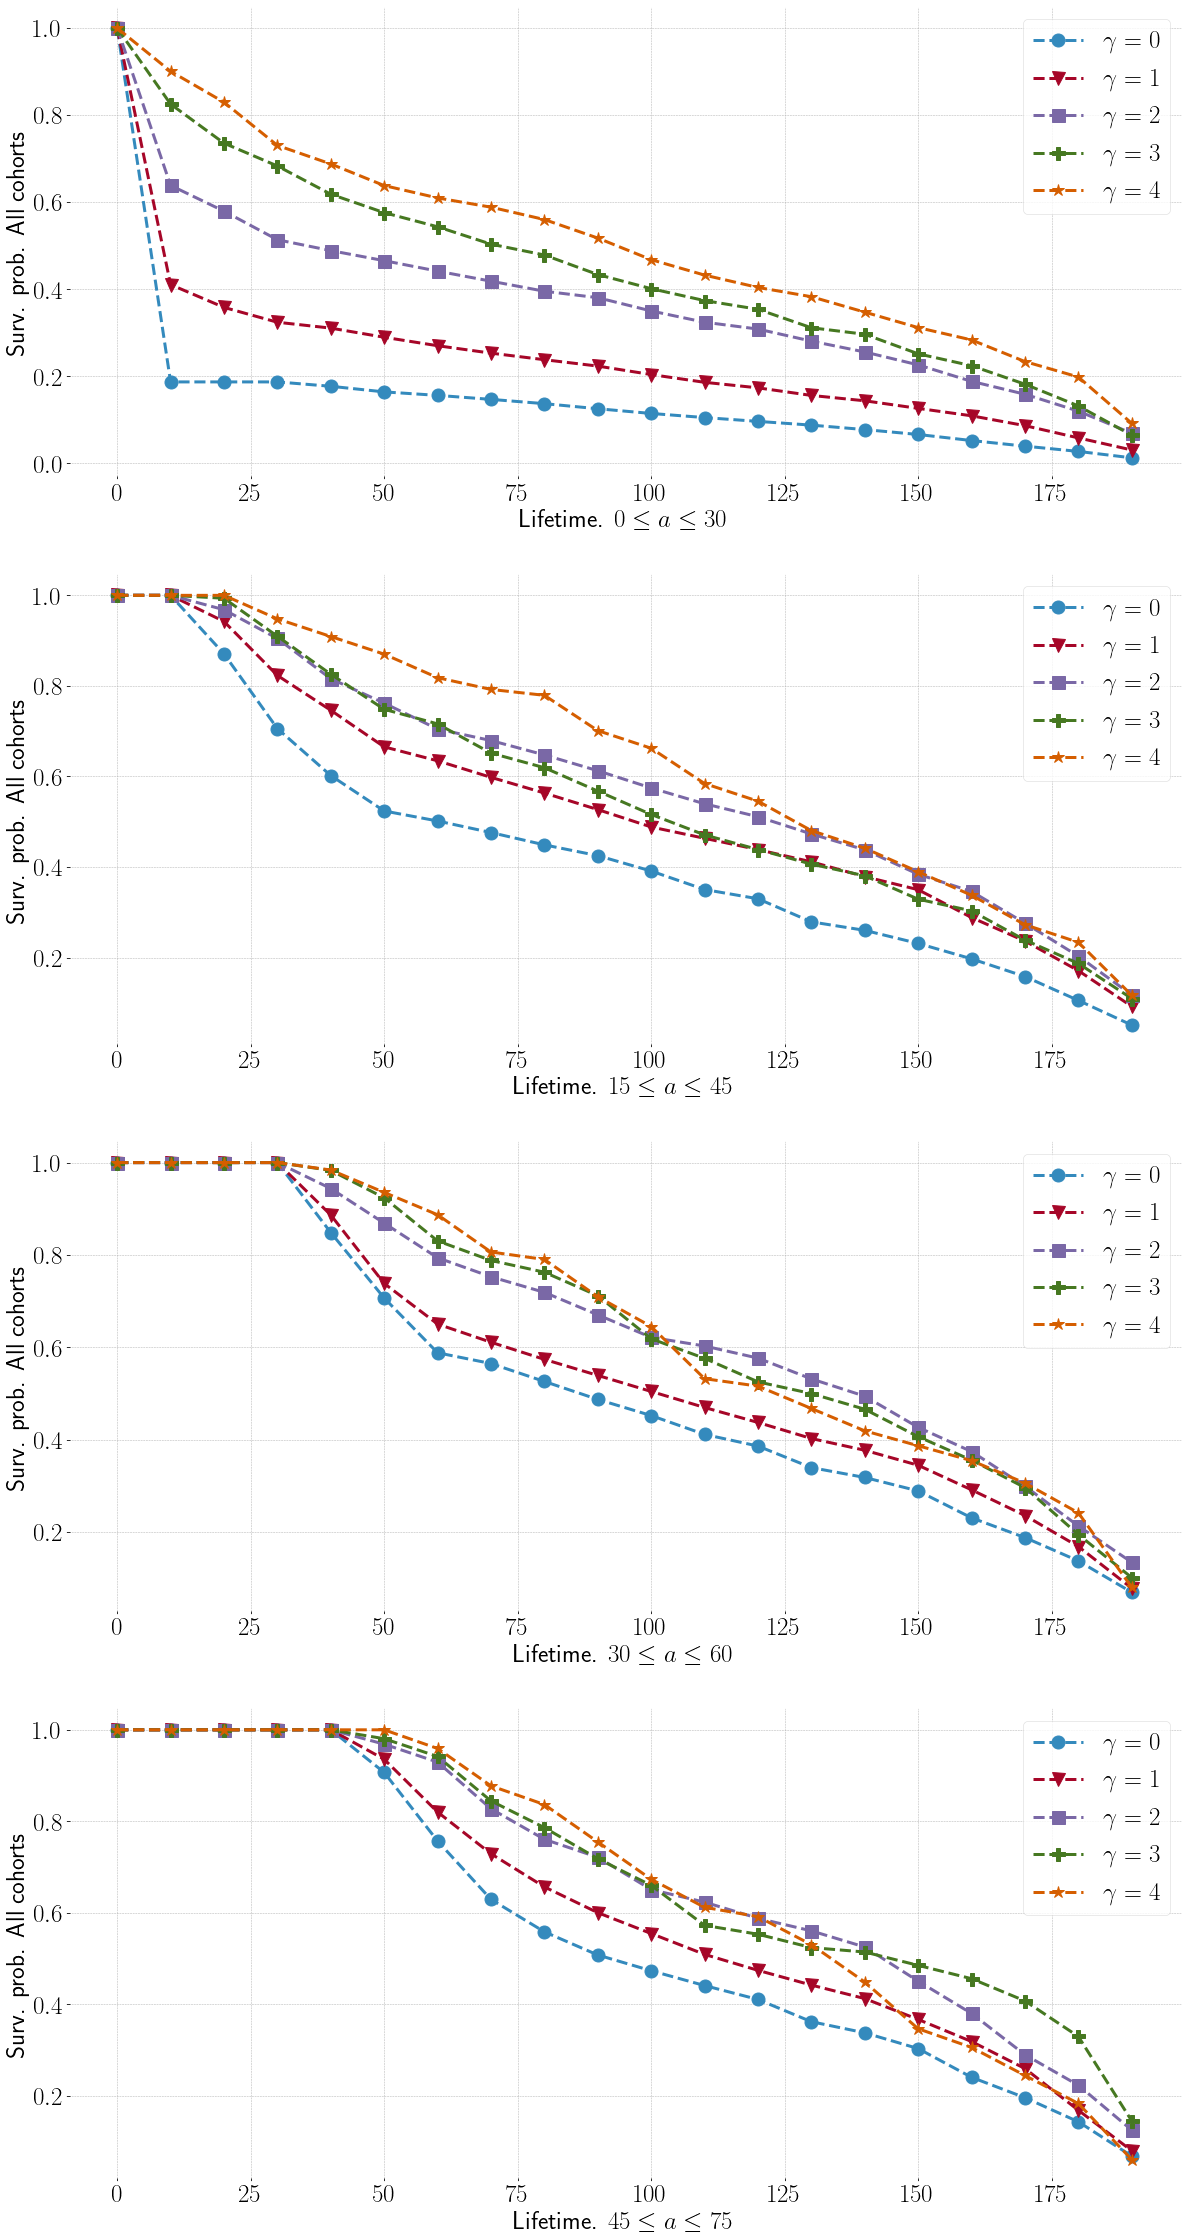

In [140]:
plt.figure(figsize=(20, 40))
p = 1
for lima in supE.keys():
    plt.subplot(4, 1, p)
    plt.xlabel(fr"Lifetime. ${limitsa[lima][0]} \leq a \leq {limitsa[lima][1]}$")
    plt.ylabel(f"Surv. prob. All cohorts")
    for i in range(5):
        plt.plot([x * 10 for x in supE2[lima][i].index], supE2[lima][i][0], marker=markers[i], markersize=13, ls="--", lw=3, label=fr'$\gamma = {i}$')
    plt.legend()
    p+=1

## Intervent times

There are two ways in which I can compute the time between phone calls.

1. By taking the difference between two consecutive phone calls.
2. By counting the number of days without communication

They both measure something similar, but I will test if the results are similar.

### Difference between consecutive calls

In [33]:
def consecutive(callsdf, ello, ellf, dayres=1):
    allie = []
    cv = []
    df = callsdf.copy()
    df['ea'] = list(zip(df['ego'], df['alter']))
    lifetime = df.groupby('ea')[['aclock']].max()
    lifetime = lifetime.loc[(lifetime['aclock'] >= ello) & (lifetime['aclock'] <= ellf)]
    use = list(lifetime.index)
    df = df[df['ea'].isin(use)]   
    for ego in df['ego'].unique():
        df1 = df.loc[df['ego'] == ego]
        for alter in df1['alter'].unique():
            df2 = df1.loc[df['alter'] == alter]
            if len(df2) > 1:
                df2 = df2.sort_values(by='time')
                ie = list(df2['aclock'].diff())[1:]
                if dayres > 1:
                    ie = [x // dayres for x in ie]
                allie += ie
                cvego = np.nanstd(ie) / np.nanmean(ie)
                if not pd.isna(cvego):
                    cv.append(np.std(ie) / np.mean(ie))
    mean = np.mean(allie)
    H = pc.histogram(allie, 30, log=False)
    Hcv = pc.histogram(cv, 30, log=False)
    return (mean, H, Hcv)

In [34]:
limits = {}
limits[0] = (0, 66)
limits[1] = (67, 133)
limits[3] = (134, 199)
limits['all'] = (0, 199)

In [35]:
t0 = dt.datetime.now()
consec = {}
for c in ['uk', 'uk2', 'mit']:
    consec[c] = {}
    for dr in [1,2,4,8,16]:
        consec[c][dr] = {}
        for k in limits.keys():
            consec[c][dr][k] = consecutive(calls[c], limits[k][0], limits[k][1], dayres=dr)
        print(f'Cohort {c}, res {dr} took {dt.datetime.now() - t0}')
        t0 = dt.datetime.now()

<ipython-input-33-7caae072927b>:20: RuntimeWarning: invalid value encountered in double_scalars
  cvego = np.nanstd(ie) / np.nanmean(ie)
<ipython-input-33-7caae072927b>:20: RuntimeWarning: invalid value encountered in double_scalars
  cvego = np.nanstd(ie) / np.nanmean(ie)


Cohort uk, res 1 took 0:00:09.957553


<ipython-input-33-7caae072927b>:20: RuntimeWarning: invalid value encountered in double_scalars
  cvego = np.nanstd(ie) / np.nanmean(ie)
<ipython-input-33-7caae072927b>:20: RuntimeWarning: invalid value encountered in double_scalars
  cvego = np.nanstd(ie) / np.nanmean(ie)


Cohort uk, res 2 took 0:00:09.917482


<ipython-input-33-7caae072927b>:20: RuntimeWarning: invalid value encountered in double_scalars
  cvego = np.nanstd(ie) / np.nanmean(ie)
<ipython-input-33-7caae072927b>:20: RuntimeWarning: invalid value encountered in double_scalars
  cvego = np.nanstd(ie) / np.nanmean(ie)


Cohort uk, res 4 took 0:00:09.923836


<ipython-input-33-7caae072927b>:20: RuntimeWarning: invalid value encountered in double_scalars
  cvego = np.nanstd(ie) / np.nanmean(ie)
<ipython-input-33-7caae072927b>:20: RuntimeWarning: invalid value encountered in double_scalars
  cvego = np.nanstd(ie) / np.nanmean(ie)
<ipython-input-33-7caae072927b>:20: RuntimeWarning: invalid value encountered in double_scalars
  cvego = np.nanstd(ie) / np.nanmean(ie)


Cohort uk, res 8 took 0:00:09.921533


<ipython-input-33-7caae072927b>:20: RuntimeWarning: invalid value encountered in double_scalars
  cvego = np.nanstd(ie) / np.nanmean(ie)
<ipython-input-33-7caae072927b>:20: RuntimeWarning: invalid value encountered in double_scalars
  cvego = np.nanstd(ie) / np.nanmean(ie)
<ipython-input-33-7caae072927b>:20: RuntimeWarning: invalid value encountered in double_scalars
  cvego = np.nanstd(ie) / np.nanmean(ie)
<ipython-input-33-7caae072927b>:20: RuntimeWarning: invalid value encountered in double_scalars
  cvego = np.nanstd(ie) / np.nanmean(ie)


Cohort uk, res 16 took 0:00:09.906587


<ipython-input-33-7caae072927b>:20: RuntimeWarning: invalid value encountered in double_scalars
  cvego = np.nanstd(ie) / np.nanmean(ie)
<ipython-input-33-7caae072927b>:20: RuntimeWarning: invalid value encountered in double_scalars
  cvego = np.nanstd(ie) / np.nanmean(ie)


Cohort uk2, res 1 took 0:00:02.851688


<ipython-input-33-7caae072927b>:20: RuntimeWarning: invalid value encountered in double_scalars
  cvego = np.nanstd(ie) / np.nanmean(ie)
<ipython-input-33-7caae072927b>:20: RuntimeWarning: invalid value encountered in double_scalars
  cvego = np.nanstd(ie) / np.nanmean(ie)


Cohort uk2, res 2 took 0:00:02.859748


<ipython-input-33-7caae072927b>:20: RuntimeWarning: invalid value encountered in double_scalars
  cvego = np.nanstd(ie) / np.nanmean(ie)
<ipython-input-33-7caae072927b>:20: RuntimeWarning: invalid value encountered in double_scalars
  cvego = np.nanstd(ie) / np.nanmean(ie)


Cohort uk2, res 4 took 0:00:02.865855


<ipython-input-33-7caae072927b>:20: RuntimeWarning: invalid value encountered in double_scalars
  cvego = np.nanstd(ie) / np.nanmean(ie)
<ipython-input-33-7caae072927b>:20: RuntimeWarning: invalid value encountered in double_scalars
  cvego = np.nanstd(ie) / np.nanmean(ie)
<ipython-input-33-7caae072927b>:20: RuntimeWarning: invalid value encountered in double_scalars
  cvego = np.nanstd(ie) / np.nanmean(ie)


Cohort uk2, res 8 took 0:00:02.852589


<ipython-input-33-7caae072927b>:20: RuntimeWarning: invalid value encountered in double_scalars
  cvego = np.nanstd(ie) / np.nanmean(ie)
<ipython-input-33-7caae072927b>:20: RuntimeWarning: invalid value encountered in double_scalars
  cvego = np.nanstd(ie) / np.nanmean(ie)
<ipython-input-33-7caae072927b>:20: RuntimeWarning: invalid value encountered in double_scalars
  cvego = np.nanstd(ie) / np.nanmean(ie)
<ipython-input-33-7caae072927b>:20: RuntimeWarning: invalid value encountered in double_scalars
  cvego = np.nanstd(ie) / np.nanmean(ie)


Cohort uk2, res 16 took 0:00:02.826712


<ipython-input-33-7caae072927b>:20: RuntimeWarning: invalid value encountered in double_scalars
  cvego = np.nanstd(ie) / np.nanmean(ie)
<ipython-input-33-7caae072927b>:20: RuntimeWarning: invalid value encountered in double_scalars
  cvego = np.nanstd(ie) / np.nanmean(ie)


Cohort mit, res 1 took 0:00:16.334695


<ipython-input-33-7caae072927b>:20: RuntimeWarning: invalid value encountered in double_scalars
  cvego = np.nanstd(ie) / np.nanmean(ie)
<ipython-input-33-7caae072927b>:20: RuntimeWarning: invalid value encountered in double_scalars
  cvego = np.nanstd(ie) / np.nanmean(ie)


Cohort mit, res 2 took 0:00:16.257764


<ipython-input-33-7caae072927b>:20: RuntimeWarning: invalid value encountered in double_scalars
  cvego = np.nanstd(ie) / np.nanmean(ie)
<ipython-input-33-7caae072927b>:20: RuntimeWarning: invalid value encountered in double_scalars
  cvego = np.nanstd(ie) / np.nanmean(ie)


Cohort mit, res 4 took 0:00:16.307131


<ipython-input-33-7caae072927b>:20: RuntimeWarning: invalid value encountered in double_scalars
  cvego = np.nanstd(ie) / np.nanmean(ie)
<ipython-input-33-7caae072927b>:20: RuntimeWarning: invalid value encountered in double_scalars
  cvego = np.nanstd(ie) / np.nanmean(ie)
<ipython-input-33-7caae072927b>:20: RuntimeWarning: invalid value encountered in double_scalars
  cvego = np.nanstd(ie) / np.nanmean(ie)


Cohort mit, res 8 took 0:00:16.290698


<ipython-input-33-7caae072927b>:20: RuntimeWarning: invalid value encountered in double_scalars
  cvego = np.nanstd(ie) / np.nanmean(ie)
<ipython-input-33-7caae072927b>:20: RuntimeWarning: invalid value encountered in double_scalars
  cvego = np.nanstd(ie) / np.nanmean(ie)
<ipython-input-33-7caae072927b>:20: RuntimeWarning: invalid value encountered in double_scalars
  cvego = np.nanstd(ie) / np.nanmean(ie)
<ipython-input-33-7caae072927b>:20: RuntimeWarning: invalid value encountered in double_scalars
  cvego = np.nanstd(ie) / np.nanmean(ie)


Cohort mit, res 16 took 0:00:16.215557


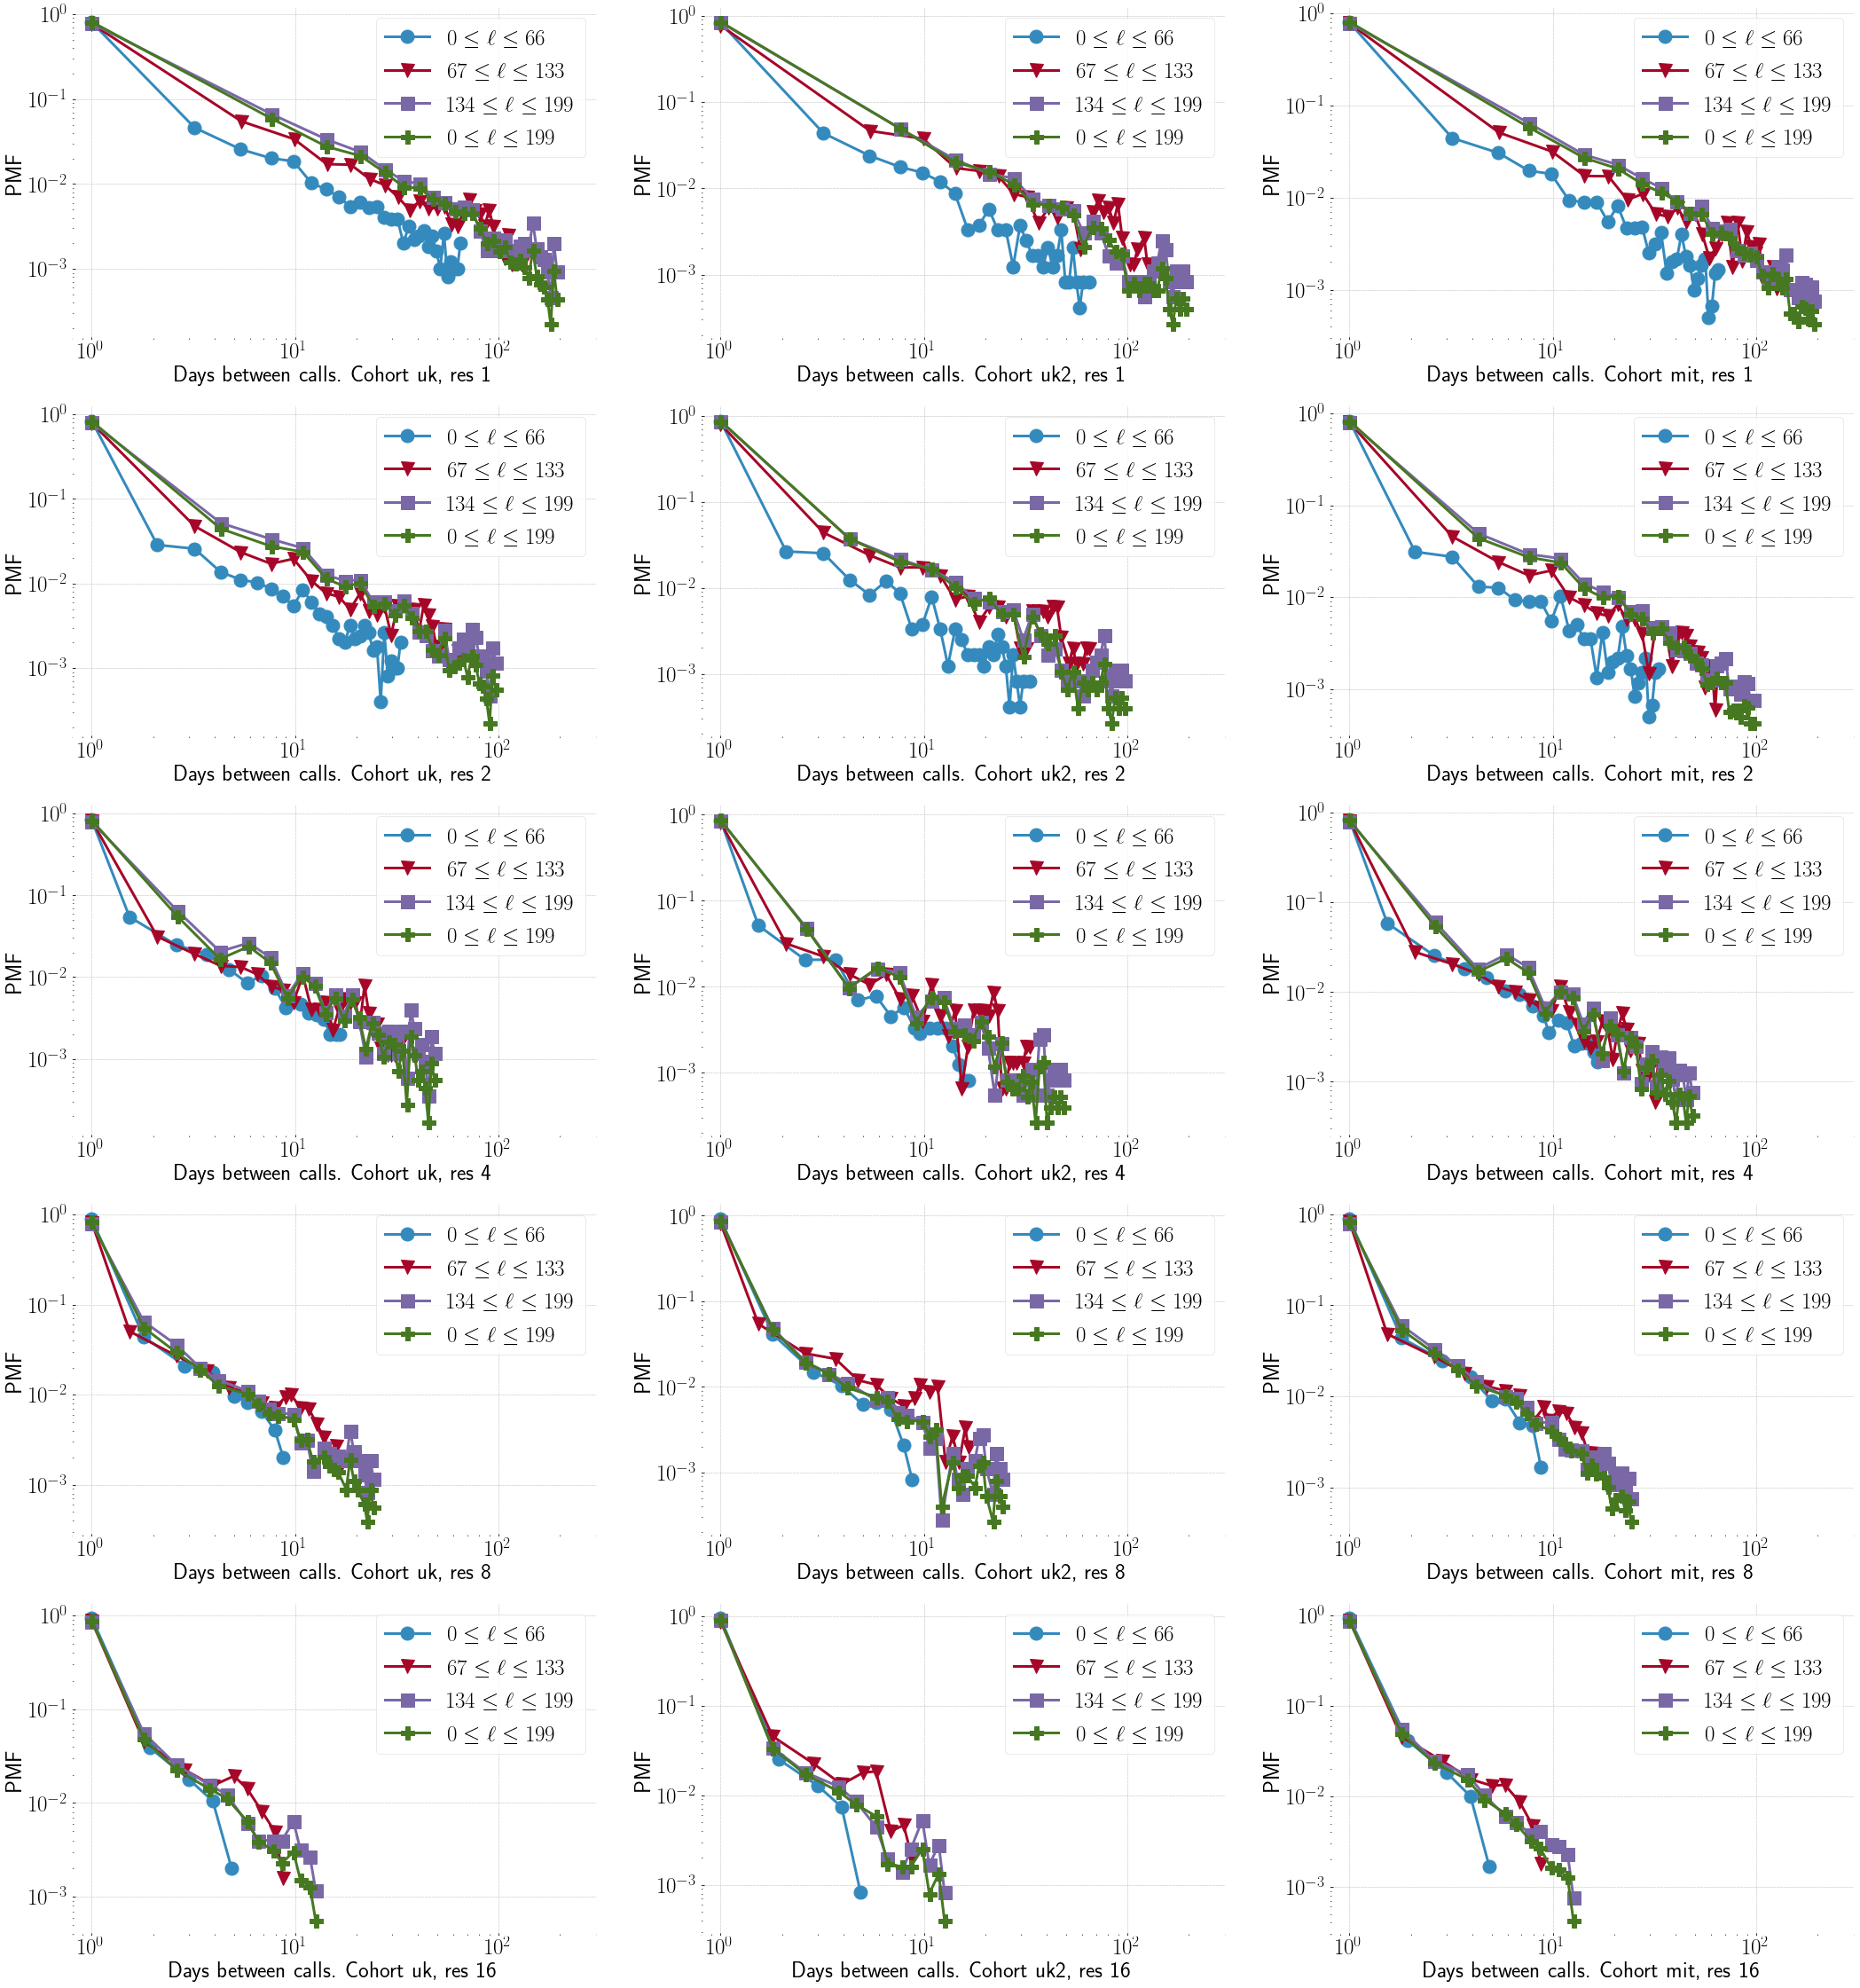

In [36]:
plt.figure(figsize=(36, 40))
p = 1
for dr in [1,2,4,8,16]:
    for c in ['uk', 'uk2', 'mit']:
        plt.subplot(5,3,p)
        plt.xlabel(f"Days between calls. Cohort {c}, res {dr}")
        plt.ylabel("PMF")
        plt.xlim(0.8, 301)
        plt.loglog()
        m = 0
        for k in consec[c][dr].keys():
            plt.plot(consec[c][dr][k][1]['label'] + 1, consec[c][dr][k][1]['pmf'], marker=markers[m], ls="-", markersize=15, lw=3, 
                     label=fr'${limits[k][0]} \leq \ell \leq {limits[k][1]}$')
            m += 1
        plt.legend()
        p += 1

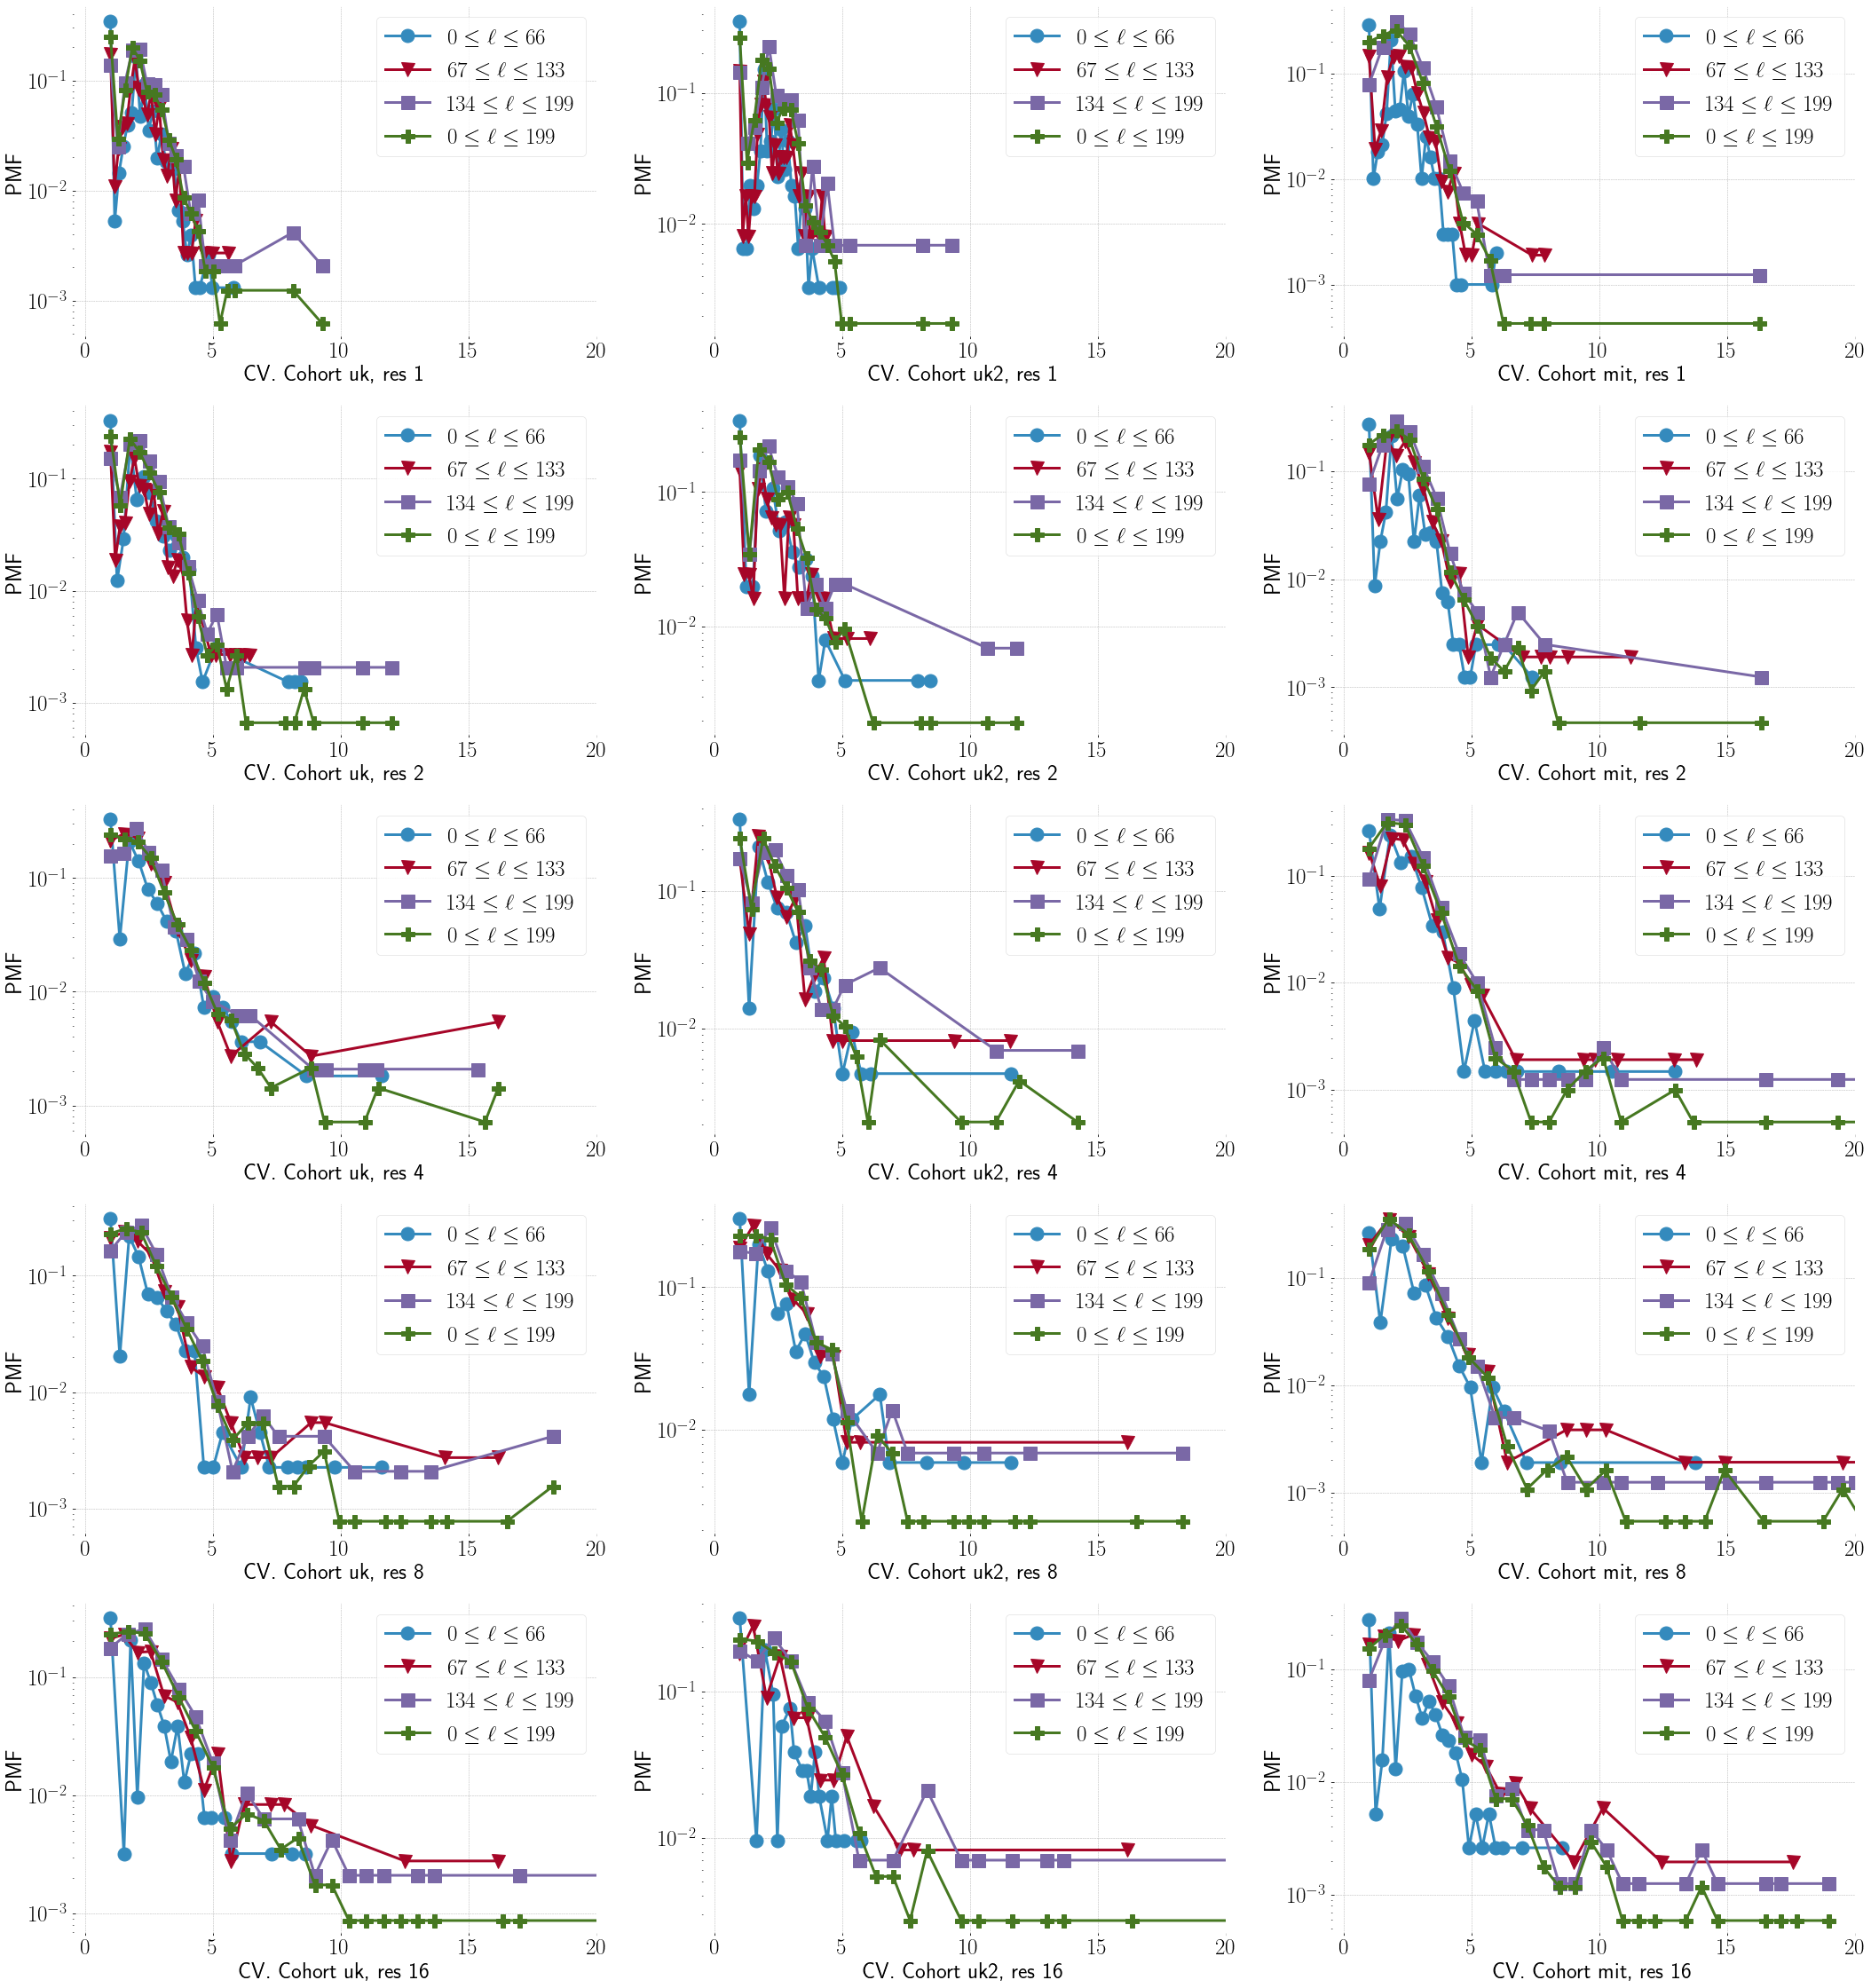

In [37]:
plt.figure(figsize=(36, 40))
p = 1
for dr in [1,2,4,8,16]:
    for c in ['uk', 'uk2', 'mit']:
        plt.subplot(5,3,p)
        plt.xlabel(f"CV. Cohort {c}, res {dr}")
        plt.ylabel("PMF")
        plt.xlim(-0.5, 20)
        plt.semilogy()
        m = 0
        for k in consec[c][dr].keys():
            plt.plot(consec[c][dr][k][2]['label'] + 1, consec[c][dr][k][2]['pmf'], marker=markers[m], ls="-", markersize=15, lw=3, 
                     label=fr'${limits[k][0]} \leq \ell \leq {limits[k][1]}$')
            m += 1
        plt.legend()
        p += 1

### Count gap length

In [38]:
def gaps(callsdf, ello, ellf, dayres=1, zero=False):
    allgaps = []
    allcv = []
    df = callsdf.copy()
    df['ea'] = list(zip(df['ego'], df['alter']))
    lifetime = df.groupby('ea')[['aclock']].max()
    lifetime = lifetime.loc[(lifetime['aclock'] >= ello) & (lifetime['aclock'] <= ellf)]
    df1 = df[df['ea'].isin(lifetime.index)]
    for ego in df1['ego'].unique():
        df2 = df1.loc[df1['ego'] == ego]
        for alter in df2['alter'].unique():
            df3 = df2.loc[df2['alter'] == alter]
            if len(df3) > 1:
                gaps = []
                df4 = df3.sort_values(by='time')
                maxa = max(df4['aclock'])
                d = 0
                for i in range(maxa + 1):
                    if i not in df4['aclock'].unique():
                        d += 1
                    elif (not zero) and (d != 0):
                        gaps.append(d)
                        d = 0
                    elif zero and d == 0:
                        gaps.append(d)
                    elif zero and d > 0:
                        gaps.append(d)
                        d = 0                        
                if dayres > 1:
                    gaps = [x // dayres for x in gaps]
                allgaps += gaps
                cv = np.nanstd(gaps) / np.nanmean(gaps)
                if not pd.isna(cv):
                    allcv.append(cv)
                    
    H = pc.histogram(allgaps, 30, log=False)
    H['label'] = H['label'].replace({0:0.1})
    Hcv = pc.histogram(allcv, 30, log=False)
    mcv = np.mean(allcv)
    scv = np.std(allcv)
    return (H, Hcv, mcv, scv)

In [39]:
t0 = dt.datetime.now()
gapsplot = {}
for c in ['uk', 'uk2', 'mit']:
    gapsplot[c] = {}
    for dr in [1,2,4,8,16]:
        gapsplot[c][dr] = {}
        for k in limits.keys():
            gapsplot[c][dr][k] = gaps(calls[c], limits[k][0], limits[k][1], dayres=dr)
        print(f'Cohort {c}, res {dr} took {dt.datetime.now() - t0}')
        t0 = dt.datetime.now()

/home/vsvh/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: Mean of empty slice
  cv = np.nanstd(gaps) / np.nanmean(gaps)
/home/vsvh/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: Mean of empty slice
  cv = np.nanstd(gaps) / np.nanmean(gaps)


Cohort uk, res 1 took 0:00:11.292255


<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
/home/vsvh/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: Mean of empty slice
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
/home/vsvh/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: Mean of empty slice
  cv = np.nanstd(gaps) / np.nanmean(gaps)


Cohort uk, res 2 took 0:00:11.369927


<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
/home/vsvh/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: Mean of empty slice
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
/home/vsvh/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: Mean of empty slice
  cv = np.nanstd(g

Cohort uk, res 4 took 0:00:11.304697


<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
/home/vsvh/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: Mean of empty slice
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
/home/vsvh/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar

Cohort uk, res 8 took 0:00:11.486446


<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
/home/vsvh/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: Mean of empty slice
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
/home/vsvh/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar

Cohort uk, res 16 took 0:00:11.398643


/home/vsvh/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: Mean of empty slice
  cv = np.nanstd(gaps) / np.nanmean(gaps)
/home/vsvh/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: Mean of empty slice
  cv = np.nanstd(gaps) / np.nanmean(gaps)


Cohort uk2, res 1 took 0:00:03.806496


/home/vsvh/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: Mean of empty slice
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
/home/vsvh/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: Mean of empty slice
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)


Cohort uk2, res 2 took 0:00:03.834033


/home/vsvh/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: Mean of empty slice
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
/home/vsvh/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: Mean of empty slice
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(g

Cohort uk2, res 4 took 0:00:03.820512


/home/vsvh/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: Mean of empty slice
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
/home/vsvh/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: Mean of empty slice
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(g

Cohort uk2, res 8 took 0:00:03.866345


/home/vsvh/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: Mean of empty slice
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
/home/vsvh/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: Mean of empty slice
  cv = np.nanstd(g

Cohort uk2, res 16 took 0:00:03.824046


/home/vsvh/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: Mean of empty slice
  cv = np.nanstd(gaps) / np.nanmean(gaps)
/home/vsvh/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: Mean of empty slice
  cv = np.nanstd(gaps) / np.nanmean(gaps)


Cohort mit, res 1 took 0:00:16.995898


/home/vsvh/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: Mean of empty slice
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
/home/vsvh/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: Mean of empty slice
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)


Cohort mit, res 2 took 0:00:16.989079


/home/vsvh/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: Mean of empty slice
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
/home/vsvh/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: Mean of empty slice
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)


Cohort mit, res 4 took 0:00:16.948827


/home/vsvh/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: Mean of empty slice
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
/home/vsvh/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: Mean of empty slice
  cv = np.nanstd(g

Cohort mit, res 8 took 0:00:17.022893


/home/vsvh/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: Mean of empty slice
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
/home/vsvh/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: Mean of empty slice
  cv = np.nanstd(g

Cohort mit, res 16 took 0:00:17.104283


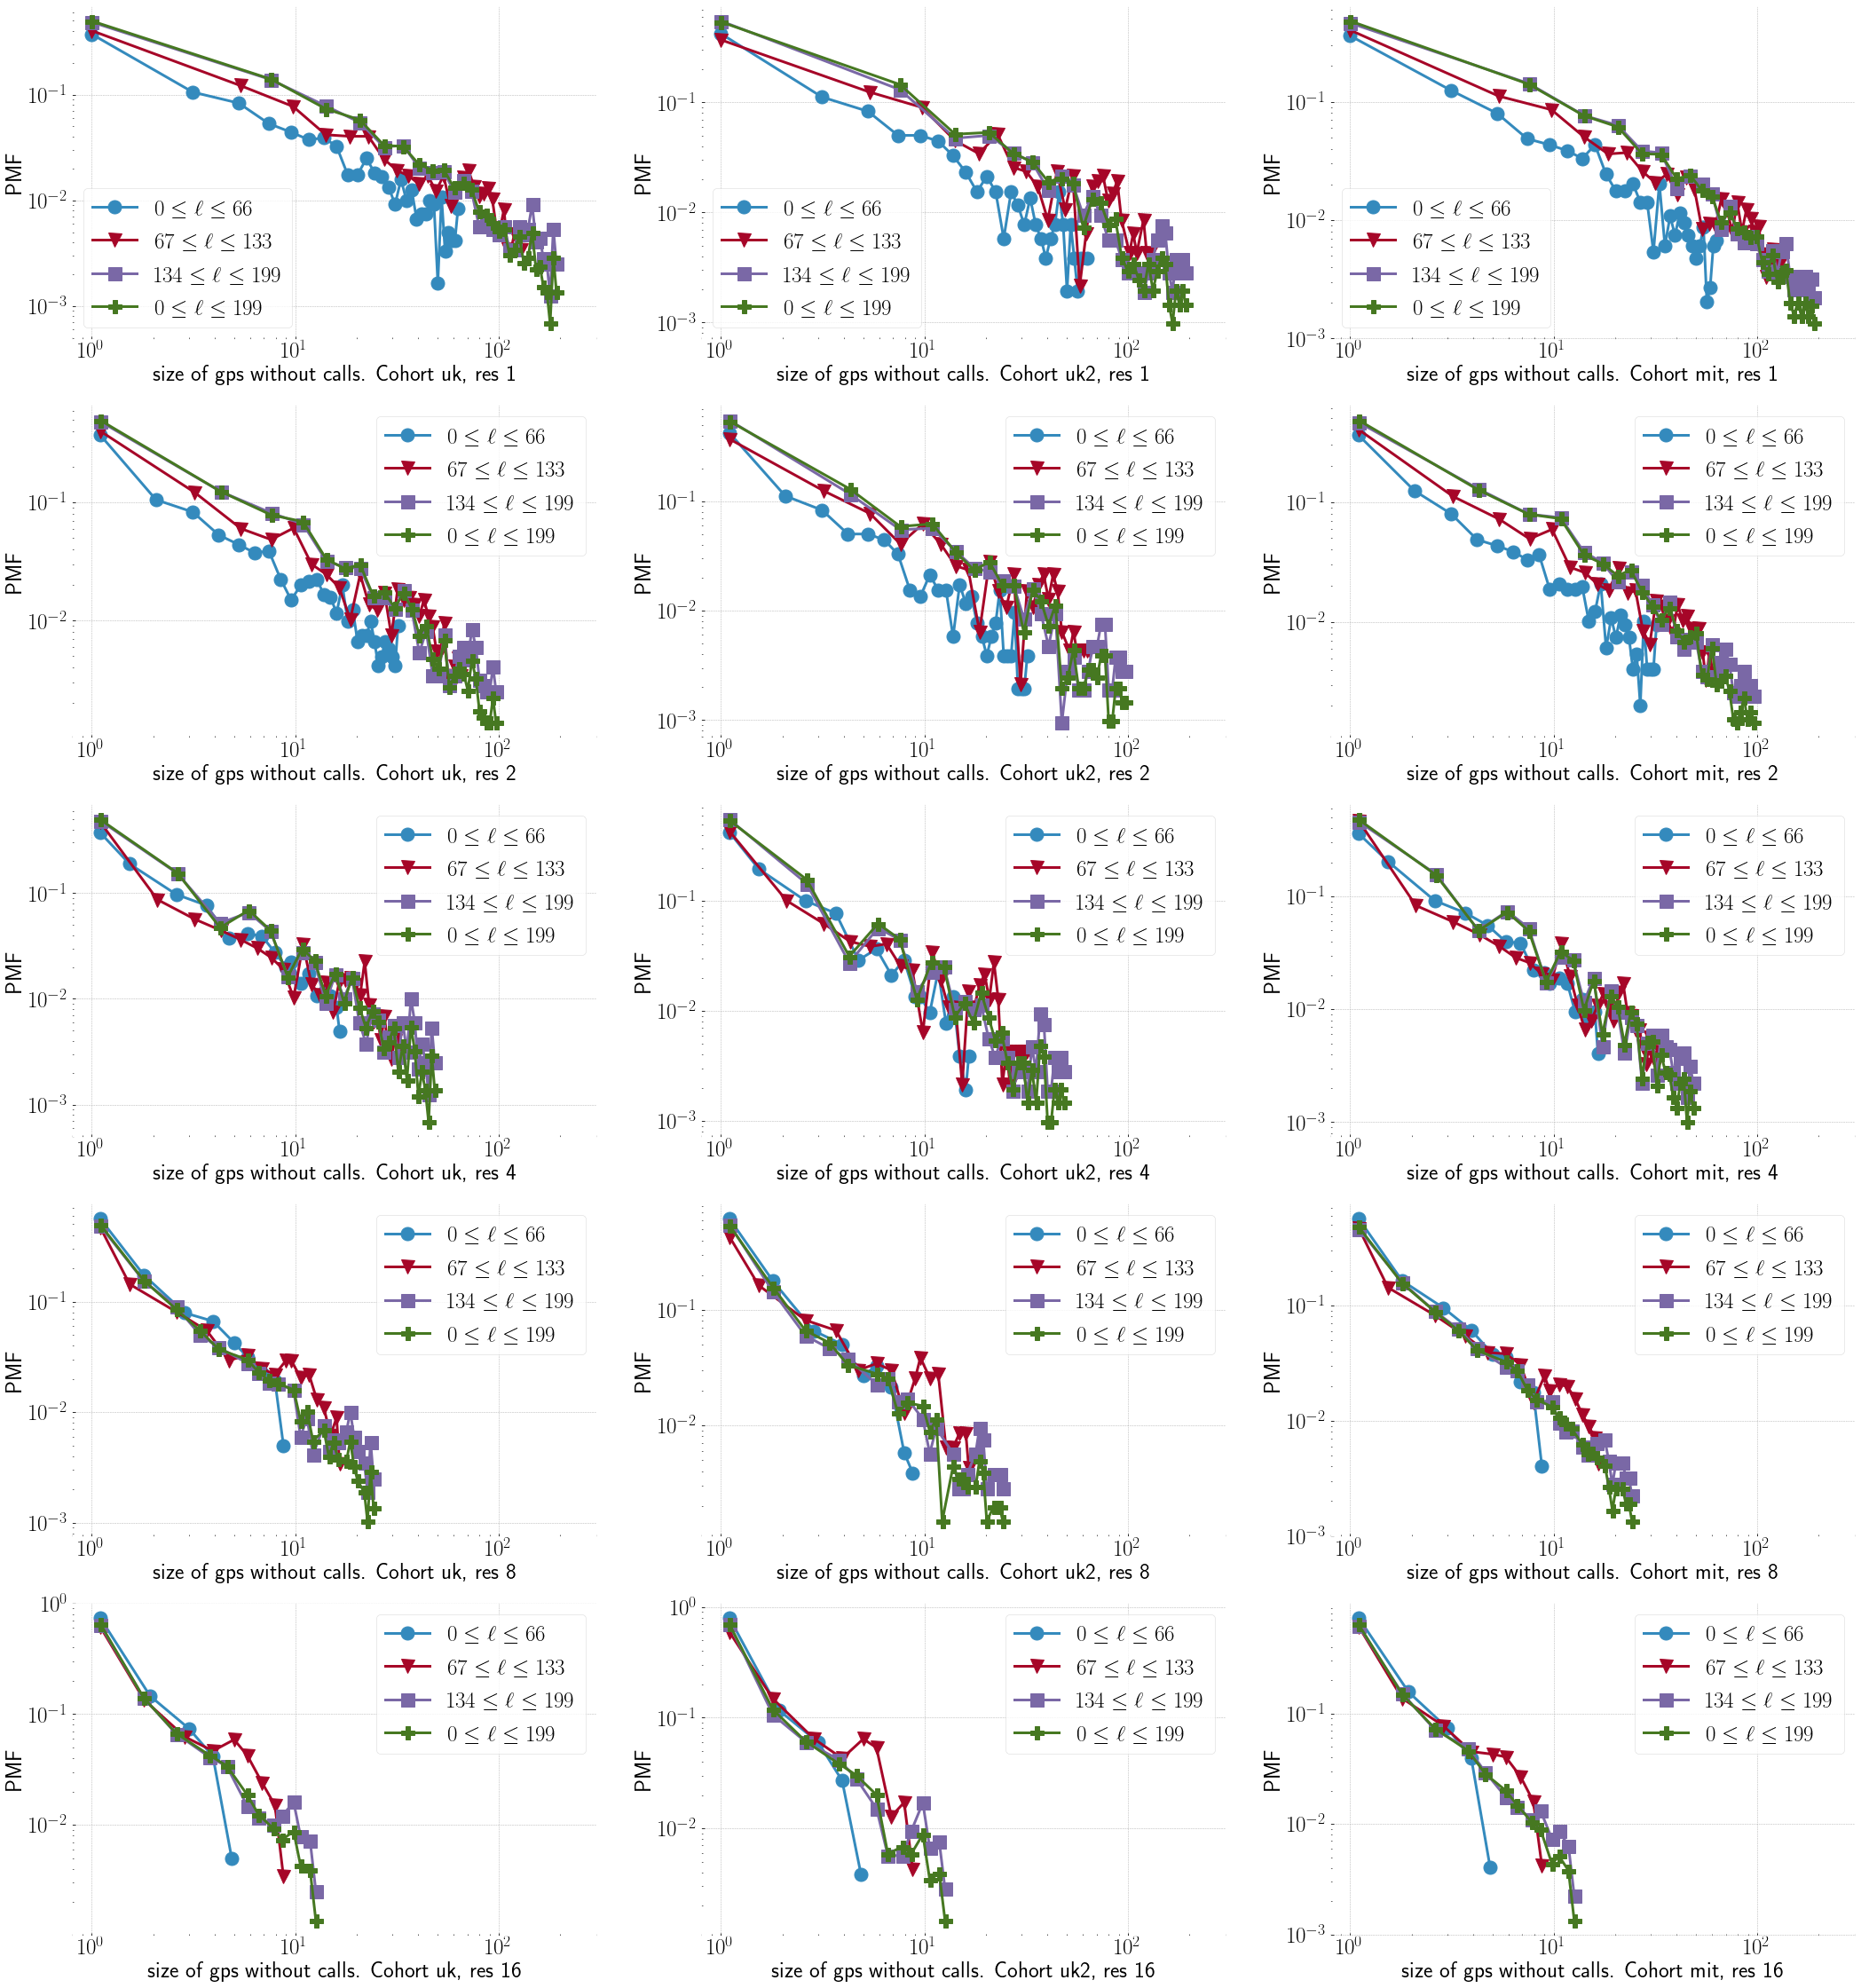

In [40]:
plt.figure(figsize=(36, 40))
p = 1
for dr in [1,2,4,8,16]:
    for c in ['uk', 'uk2', 'mit']:
        plt.subplot(5,3,p)
        plt.xlabel(f"size of gps without calls. Cohort {c}, res {dr}")
        plt.ylabel("PMF")
        plt.loglog()
        plt.xlim(0.8, 301)
        m = 0
        for k in gapsplot[c][dr].keys():
            if dr == 1:
                plt.plot(gapsplot[c][dr][k][0]['label'], gapsplot[c][dr][k][0]['pmf'], marker=markers[m], ls="-", markersize=15, lw=3,
                     label=fr'${limits[k][0]} \leq \ell \leq {limits[k][1]}$')
            else:
                plt.plot(gapsplot[c][dr][k][0]['label'] + 1, gapsplot[c][dr][k][0]['pmf'], marker=markers[m], ls="-", markersize=15, lw=3,
                     label=fr'${limits[k][0]} \leq \ell \leq {limits[k][1]}$')
            m += 1
        plt.legend()
        p += 1

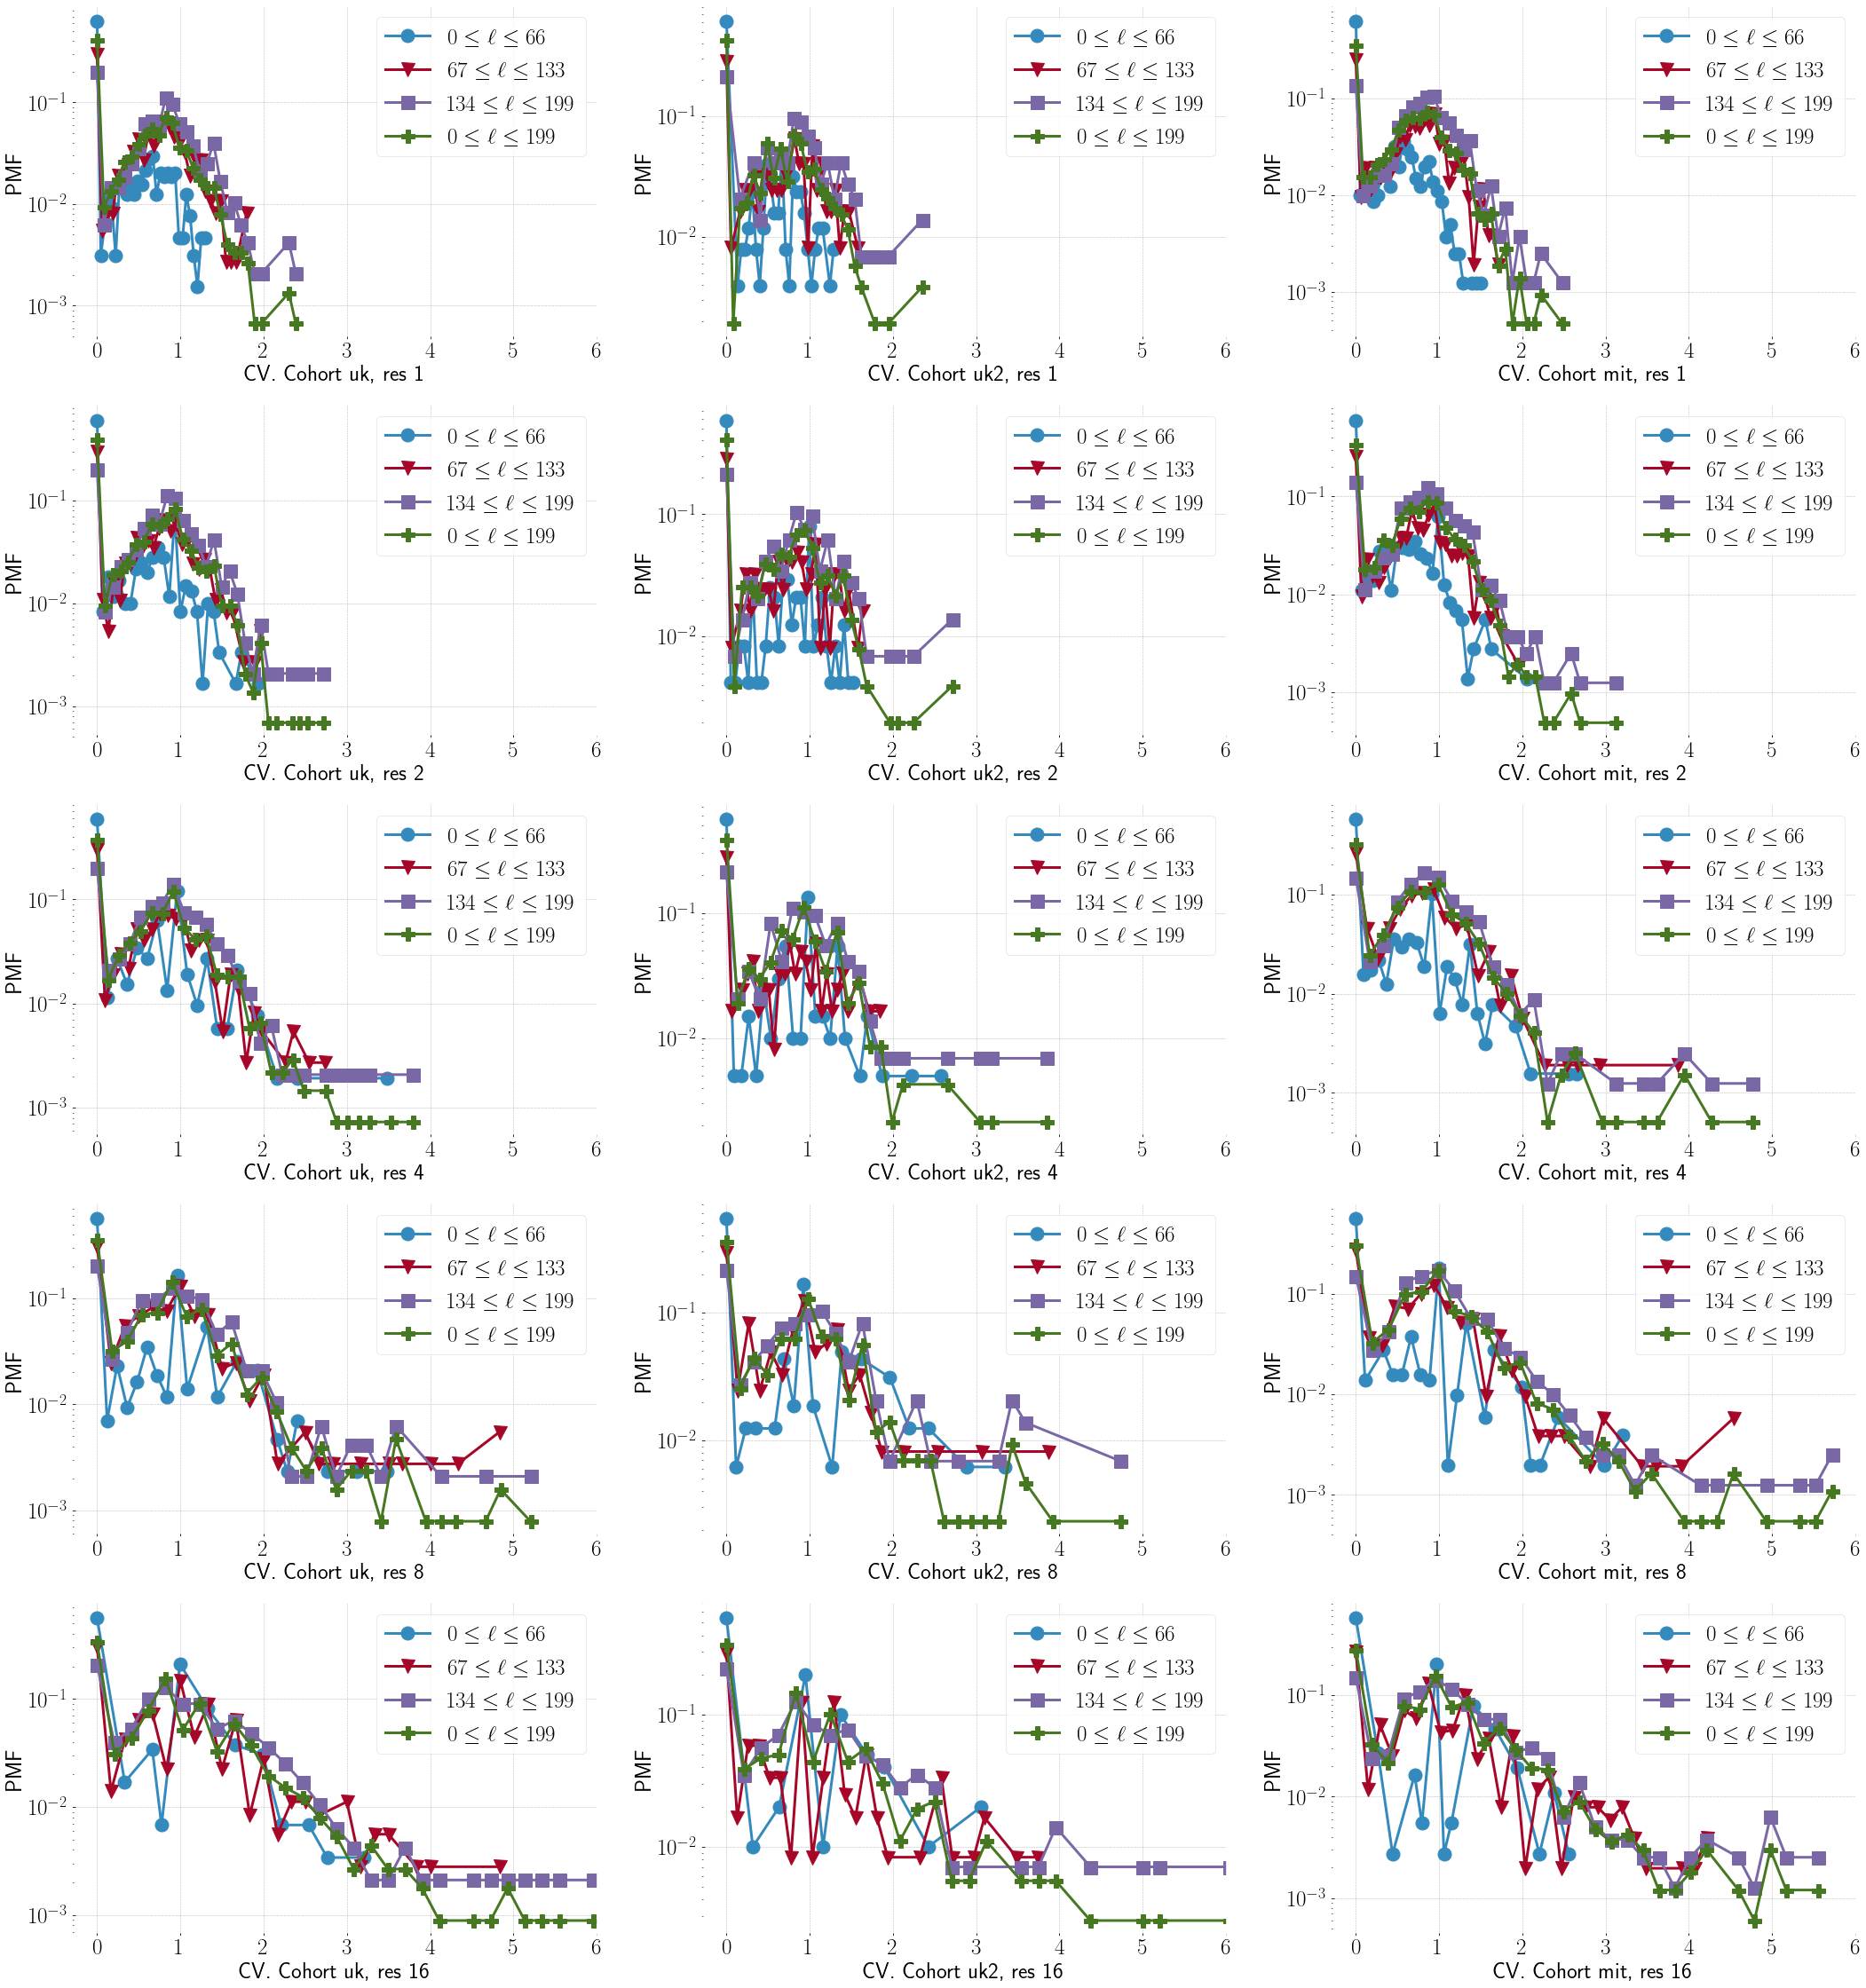

In [41]:
plt.figure(figsize=(36, 40))
p = 1
for dr in [1,2,4,8,16]:
    for c in ['uk', 'uk2', 'mit']:
        plt.subplot(5,3,p)
        plt.xlabel(f"CV. Cohort {c}, res {dr}")
        plt.ylabel("PMF")
        plt.xlim(-0.3, 6)
        plt.semilogy()
        m = 0
        for k in gapsplot[c][dr].keys():
            plt.plot(gapsplot[c][dr][k][1]['label'], gapsplot[c][dr][k][1]['pmf'], marker=markers[m], ls="-", markersize=15, lw=3, 
                     label=fr'${limits[k][0]} \leq \ell \leq {limits[k][1]}$')
            m += 1
        plt.legend()
        p += 1

### Gaps including zero

In [42]:
t0 = dt.datetime.now()
gapsplot2 = {}
for c in ['uk', 'uk2', 'mit']:
    gapsplot2[c] = {}
    for dr in [1,2,4,8,16]:
        gapsplot2[c][dr] = {}
        for k in limits.keys():
            gapsplot2[c][dr][k] = gaps(calls[c], limits[k][0], limits[k][1], dayres=dr, zero=True)
        print(f'Cohort {c}, res {dr} took {dt.datetime.now() - t0}')
        t0 = dt.datetime.now()

<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)


Cohort uk, res 1 took 0:00:11.572289


<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)


Cohort uk, res 2 took 0:00:11.540051


<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)


Cohort uk, res 4 took 0:00:11.529764


<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)


Cohort uk, res 8 took 0:00:11.523644


<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)


Cohort uk, res 16 took 0:00:11.757998


<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)


Cohort uk2, res 1 took 0:00:03.970433


<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)


Cohort uk2, res 2 took 0:00:03.847723


<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)


Cohort uk2, res 4 took 0:00:03.792760


<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)


Cohort uk2, res 8 took 0:00:03.808327


<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)


Cohort uk2, res 16 took 0:00:03.788584


<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)


Cohort mit, res 1 took 0:00:16.869456


<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)


Cohort mit, res 2 took 0:00:16.916194


<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)


Cohort mit, res 4 took 0:00:16.964031


<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)


Cohort mit, res 8 took 0:00:17.185157


<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)
<ipython-input-38-f019f6aa93d2>:32: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.nanstd(gaps) / np.nanmean(gaps)


Cohort mit, res 16 took 0:00:17.008217


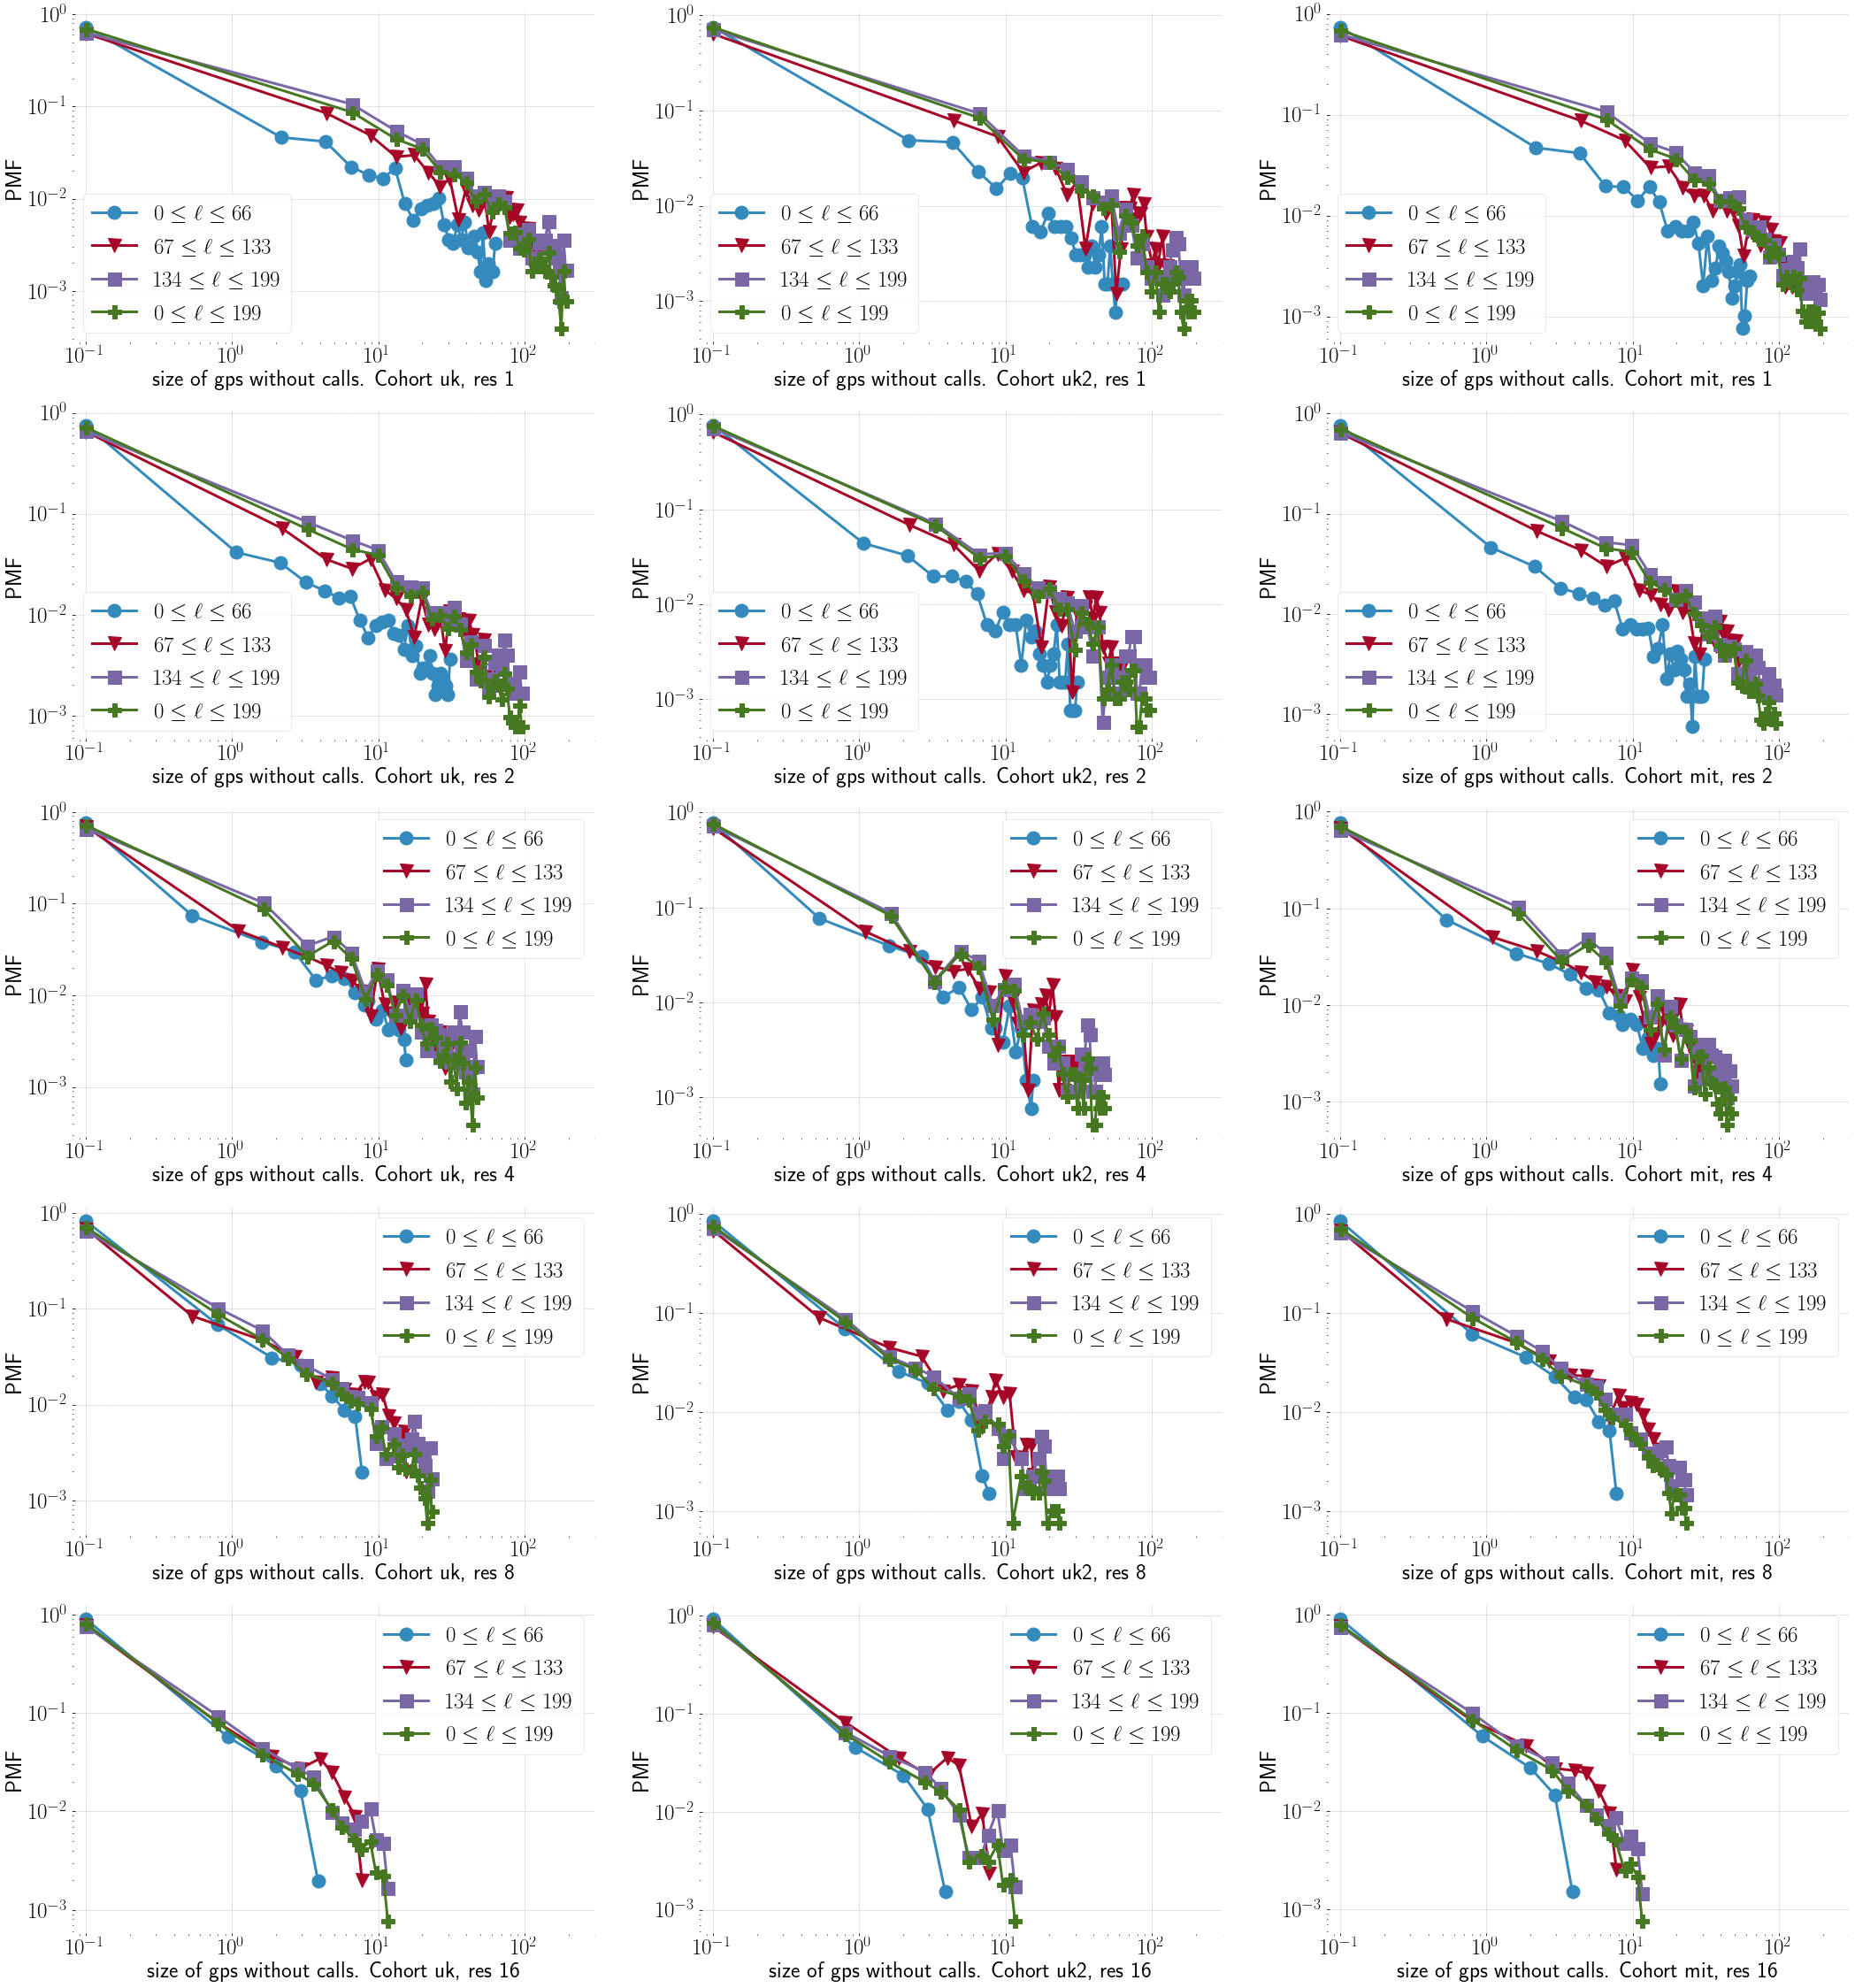

In [43]:
plt.figure(figsize=(36, 40))
p = 1
for dr in [1,2,4,8,16]:
    for c in ['uk', 'uk2', 'mit']:
        plt.subplot(5,3,p)
        plt.xlabel(f"size of gps without calls. Cohort {c}, res {dr}")
        plt.ylabel("PMF")
        plt.loglog()
        plt.xlim(0.08, 301)
        m = 0
        plt.plot(gapsplot2[c][dr][k][0]['label'], gapsplot2[c][dr][k][0]['pmf'], marker=markers[m], ls="-", markersize=15, lw=3,
                     label=fr'Seconds')
            m += 1
        plt.legend()
        p += 1

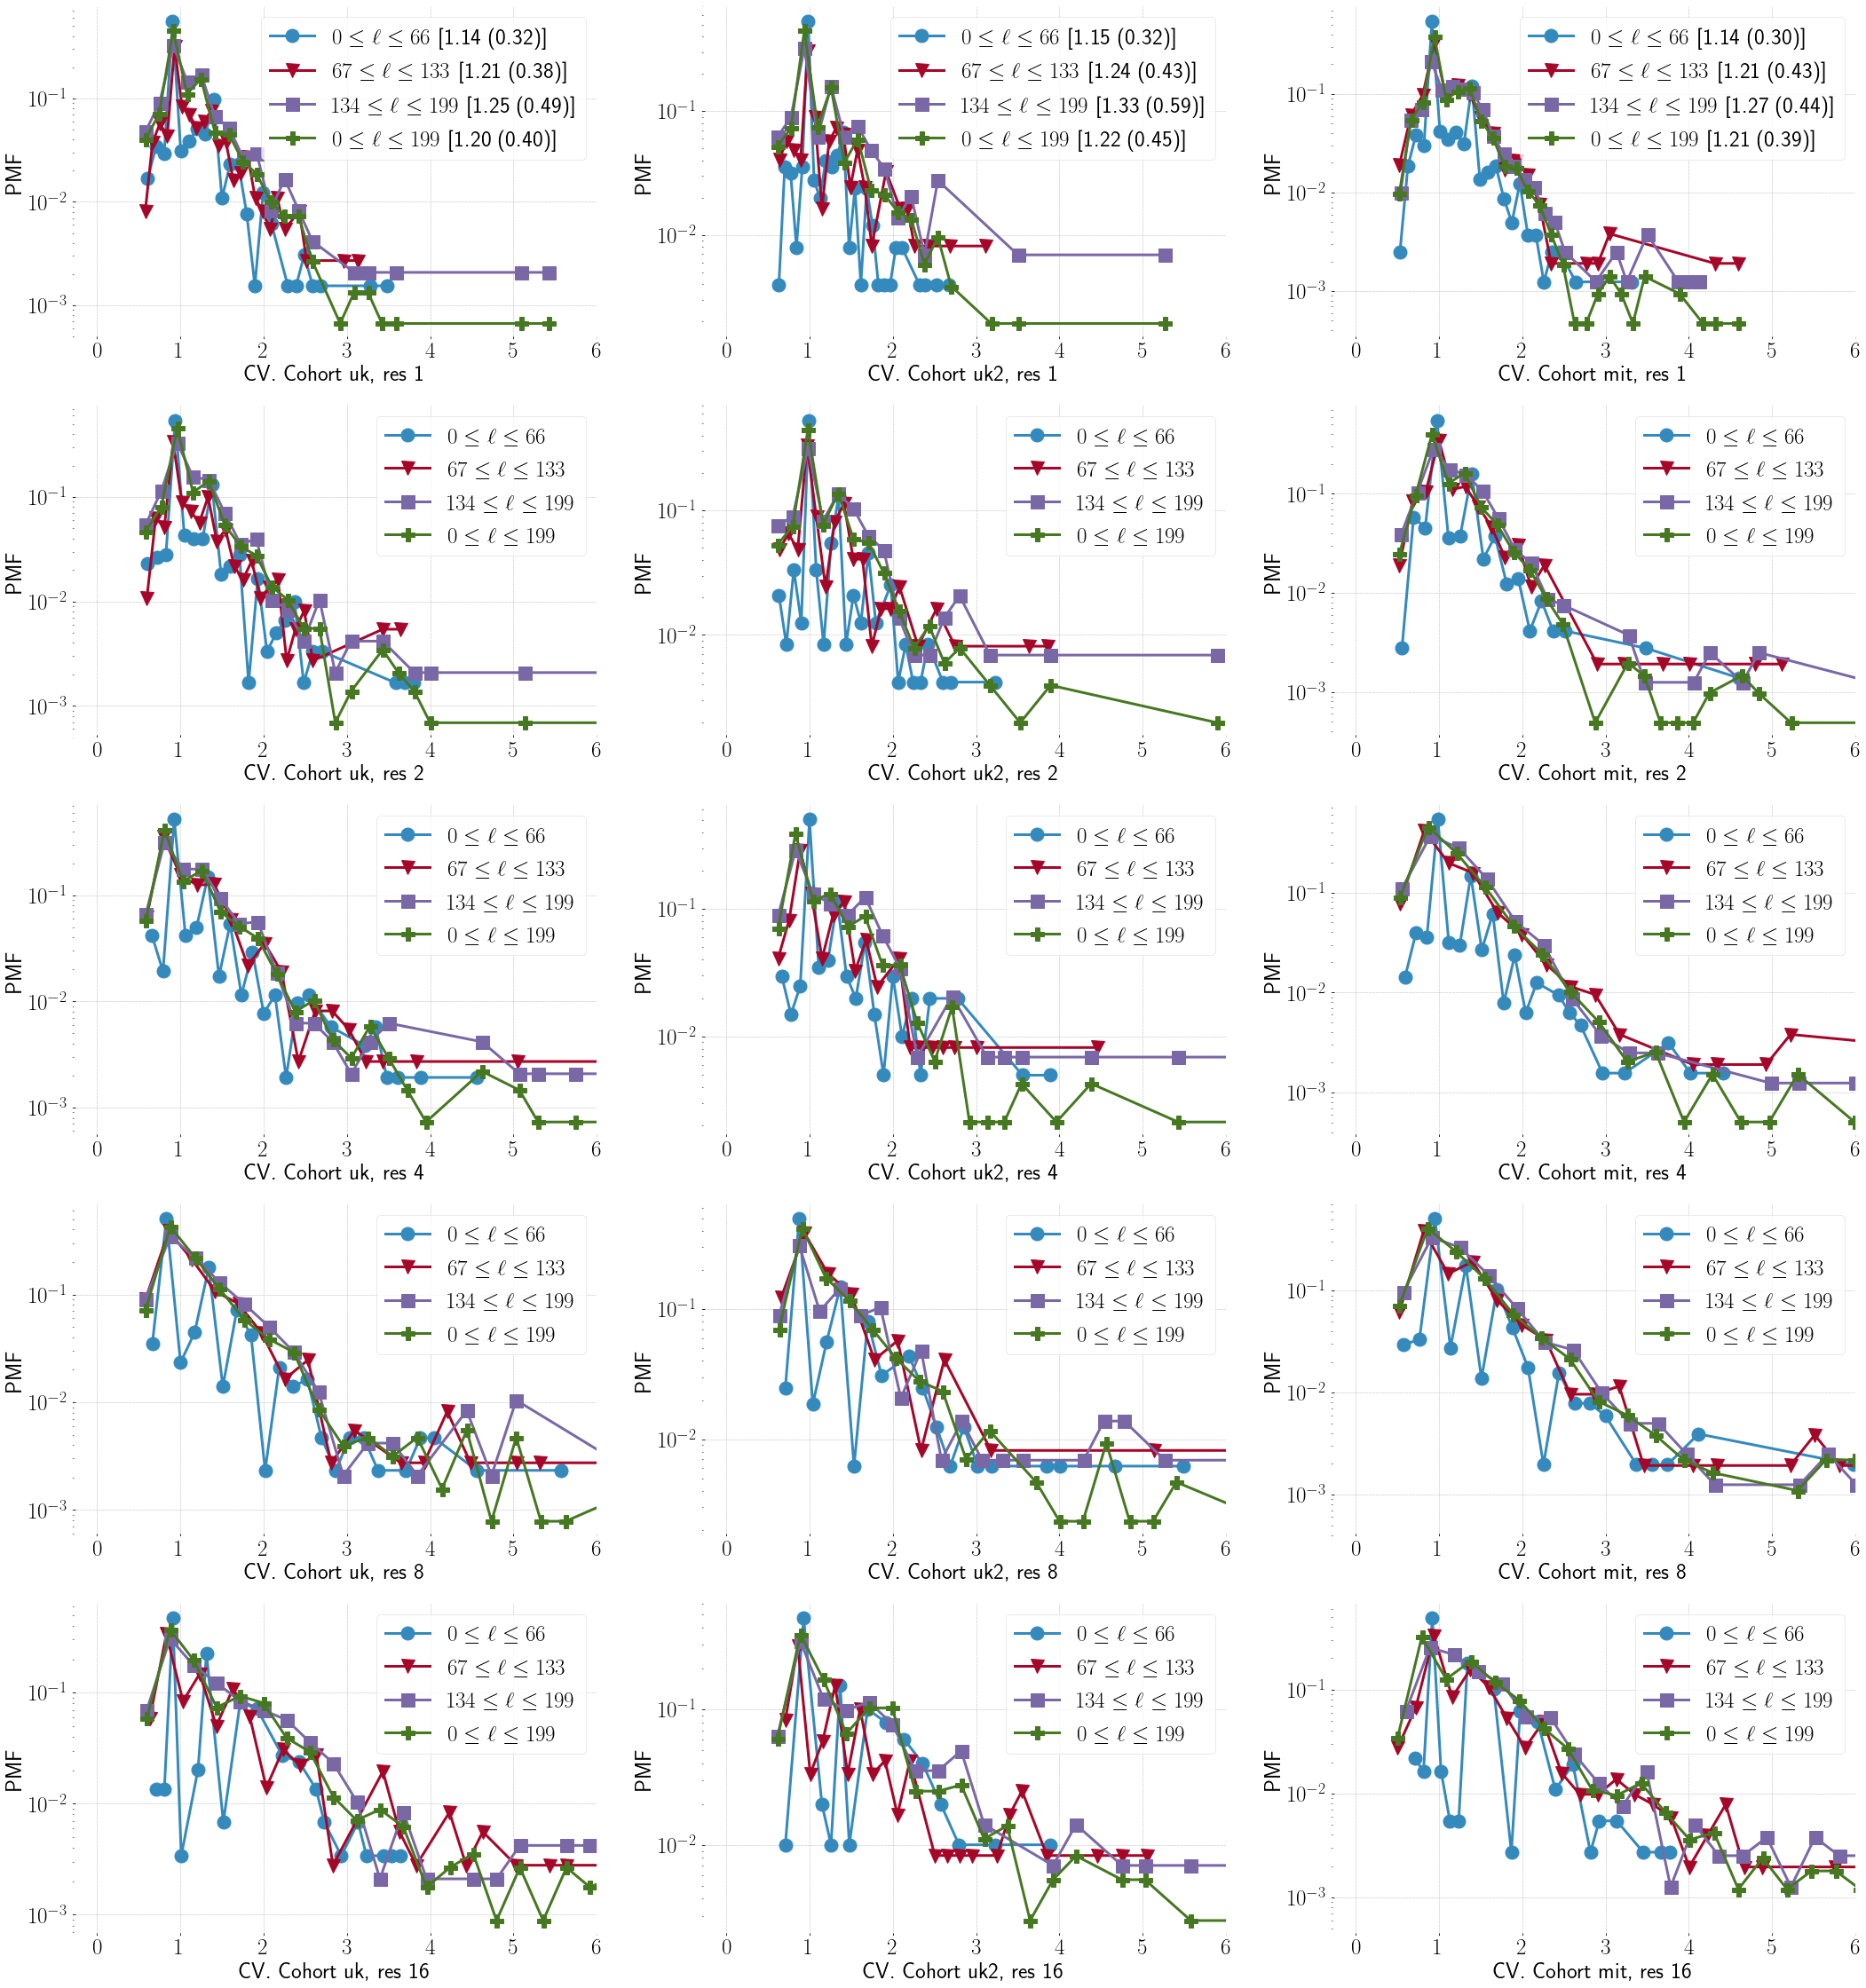

In [44]:
plt.figure(figsize=(36, 40))
p = 1
for dr in [1,2,4,8,16]:
    for c in ['uk', 'uk2', 'mit']:
        plt.subplot(5,3,p)
        plt.xlabel(f"CV. Cohort {c}, res {dr}")
        plt.ylabel("PMF")
        plt.xlim(-0.3, 6)
        plt.semilogy()
        m = 0
        for k in gapsplot2[c][dr].keys():
            if dr != 1:
                plt.plot(gapsplot2[c][dr][k][1]['label'], gapsplot2[c][dr][k][1]['pmf'], marker=markers[m], ls="-", markersize=15, lw=3, 
                     label=fr'${limits[k][0]} \leq \ell \leq {limits[k][1]}$')
            else:
                plt.plot(gapsplot2[c][dr][k][1]['label'], gapsplot2[c][dr][k][1]['pmf'], marker=markers[m], ls="-", markersize=15, lw=3, 
                     label=fr'${limits[k][0]} \leq \ell \leq {limits[k][1]}$ [{gapsplot2[c][dr][k][2]:.2f} ({gapsplot2[c][dr][k][3]:.2f})]')
            m += 1
        plt.legend()
        p += 1

### Lowering resolution

In [45]:
def calls_by_second(callsdf):
    df = callsdf.copy(deep=True)
    minT = min(df['time'])
    df['u'] = (df['time'] - minT).dt.total_seconds()
    df['ea'] = list(zip(df['ego'], df['alter']))
    ulocmin = df.groupby('ea')[['u']].min()
    df['a'] = df.index.map(lambda i: df.at[i, 'u'] - ulocmin['u'][df.at[i, 'ea']])
    df = df.sort_values(by=['ego', 'alter', 'time'])
    g = df.groupby('ea')[['time']].count()
    old = len(df['ea'].unique())
    g = g.loc[g['time'] > 3]
    df = df[df['ea'].isin(g.index)]
    new = len(df['ea'].unique())
    print(f'lost {old - new} pairs')
    df = df.drop(columns=['ea'])
    return df

In [46]:
t0 = dt.datetime.now()
calls_bys = {}
for c in calls.keys():
    df = calls[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    g = df.groupby('ea')[['time']].count()
    old = len(df['ea'].unique())
    g = g.loc[g['time'] > 3]
    df = df[df['ea'].isin(g.index)]
    new = len(df['ea'].unique())
    print(f'Cohort {c} lost {old - new} pairs')
    calls_bys[c] = calls_by_second(df)
print(f'Took {dt.datetime.now() - t0}')

Cohort uk lost 2953 pairs
lost 0 pairs
Cohort uk2 lost 1171 pairs
lost 0 pairs
Cohort mit lost 3462 pairs
lost 0 pairs
Took 0:00:02.238457


In [68]:
def consecutive_bys(callsdf, ello, ellf, nolives = True):
    allie = []
    cv = []
    goodp = 0
    badp = 0
    df = callsdf.copy()
    df['ea'] = list(zip(df['ego'], df['alter']))
    if type(nolives) != pd.core.frame.DataFrame:
        lifetime = df.groupby('ea')[['aclock']].max()
        lifetime = lifetime.loc[(lifetime['aclock'] >= ello) & (lifetime['aclock'] <= ellf)]
        use = list(lifetime.index)
    else:
        df_alt = nolives.copy(deep=True)
        df_alt['ea'] = list(zip(df_alt['ego'], df_alt['alter']))
        lifetime = df_alt.groupby('ea')[['aclock']].max()
        lifetime = lifetime.loc[(lifetime['aclock'] >= ello) & (lifetime['aclock'] <= ellf)]
        use = list(lifetime.index)
    df = df[df['ea'].isin(use)]
    for ego in df['ego'].unique():
        df1 = df.loc[df['ego'] == ego]
        for alter in df1['alter'].unique():
            df2 = df1.loc[df['alter'] == alter]
            if len(df2) > 1:
                df2 = df2.sort_values(by='time')
                ie = list(df2['a'].diff())[1:]
                allie += ie
                cvego = np.nanstd(ie) / np.nanmean(ie)
                if not pd.isna(cvego):
                    cv.append(np.std(ie) / np.mean(ie))
                    goodp += 1
                else:
                    bad += 1
    mean = np.mean(cv)
    std = np.std(cv)
    H = pc.histogram(allie, 30, log=False)
    Hcv = pc.histogram(cv, 30, log=False)
    return (H, Hcv, mean, std, goodp, badp)

In [49]:
t0 = dt.datetime.now()
consec_bys = {}
for c in ['uk', 'uk2', 'mit']:
    consec_bys[c] = {}
    for k in limits.keys():
        consec_bys[c][k] = consecutive_bys(calls_bys[c], limits[k][0], limits[k][1])
    print(f'Cohort {c} took {dt.datetime.now() - t0}')
    t0 = dt.datetime.now()

Cohort uk took 0:00:03.178840
Cohort uk2 took 0:00:00.967641
Cohort mit took 0:00:06.280557


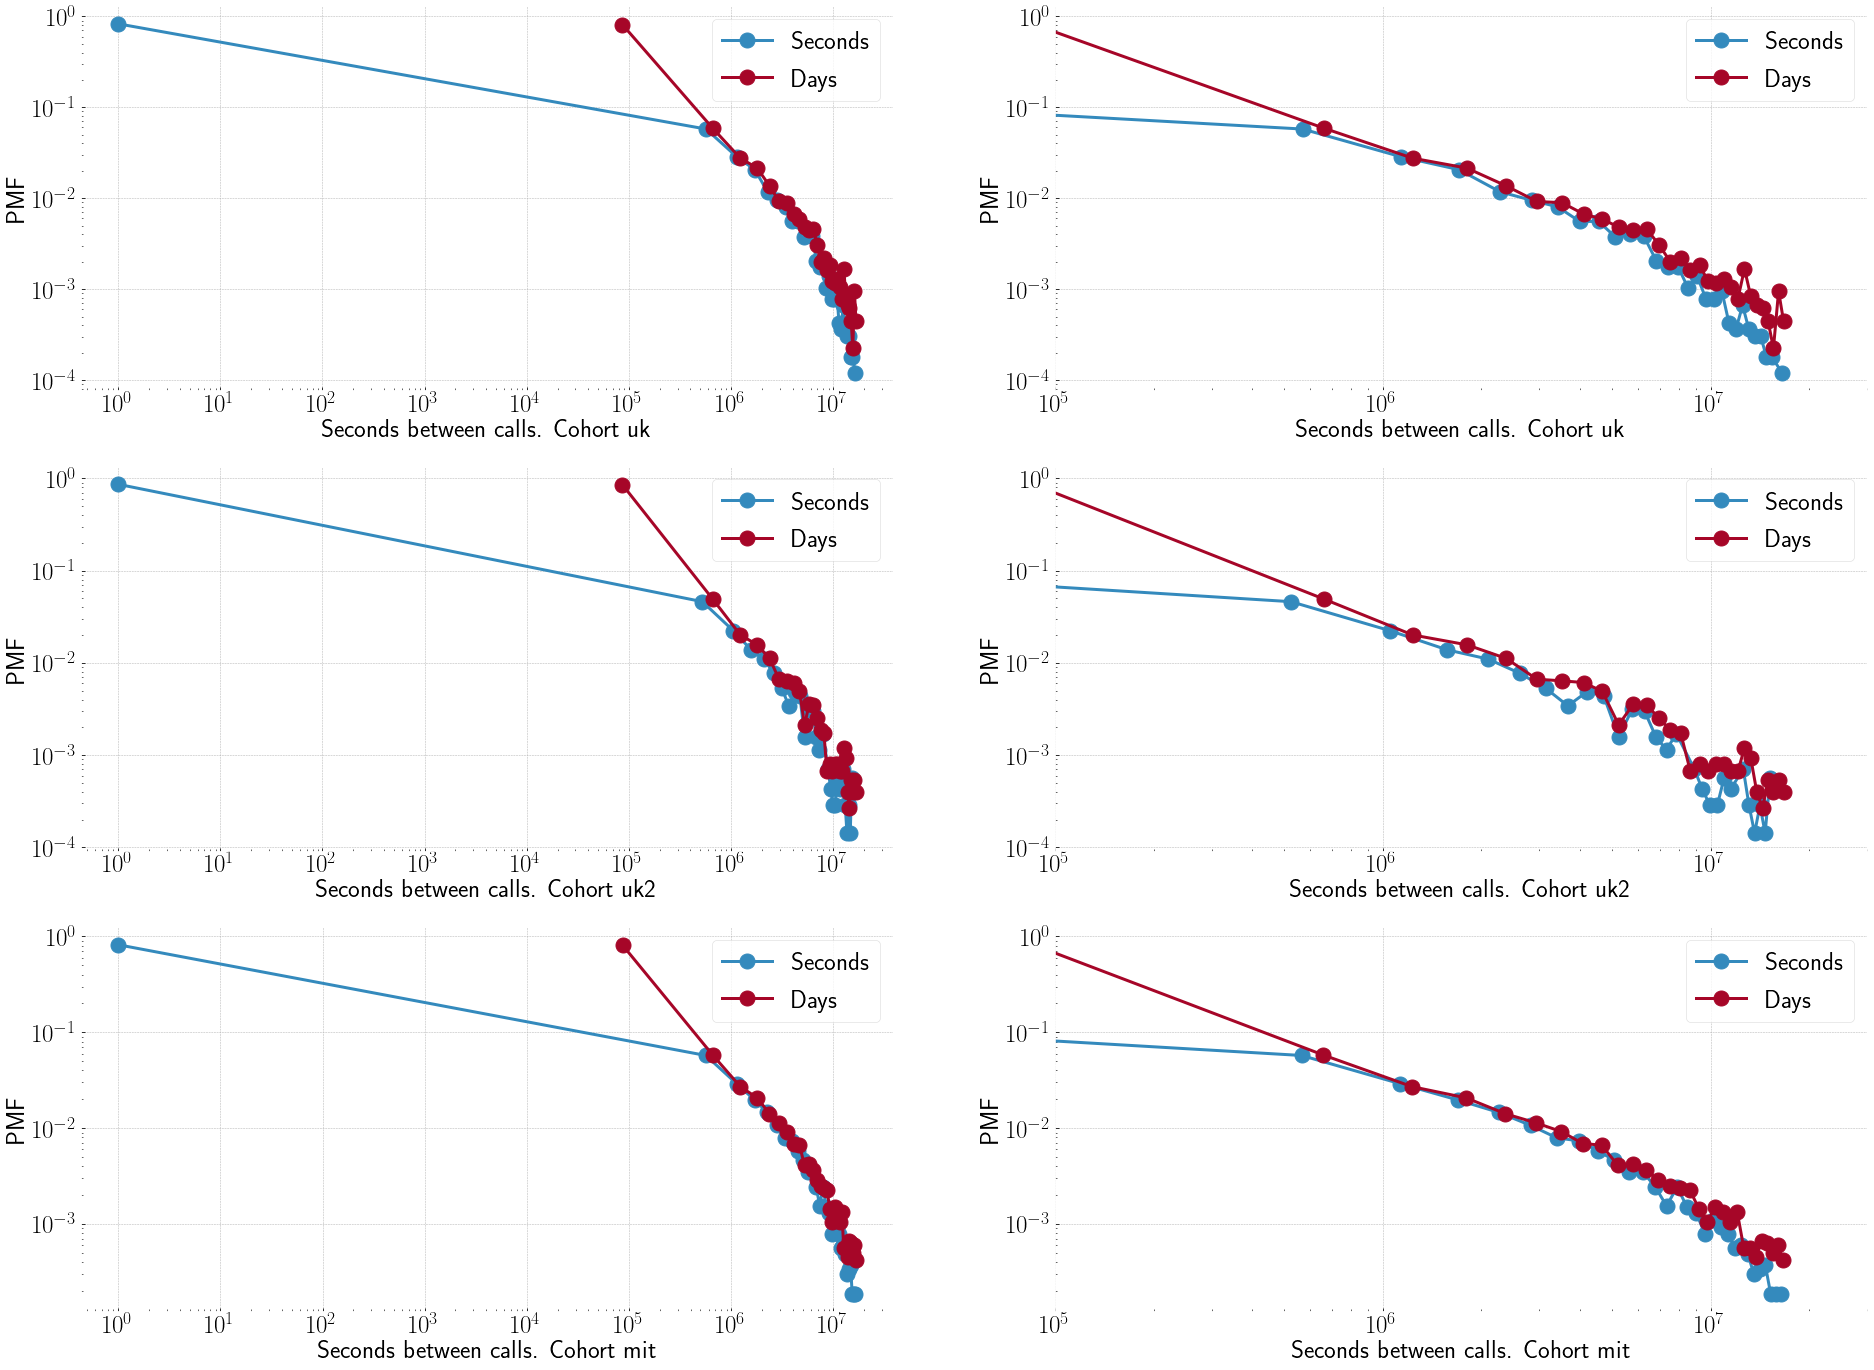

In [121]:
plt.figure(figsize=(32, 24))
p = 1
for c in ['uk', 'uk2', 'mit']:
    for col in ['l', 'r']:
        plt.subplot(3,2,p)
        plt.xlabel(f"Seconds between calls. Cohort {c}")
        plt.ylabel("PMF")
        if col == 'r':
            plt.xlim(10**5, 3*10**7)
        plt.loglog()
        m = 0
        plt.plot(consec_bys[c]['all'][0]['label'] + 1, consec_bys[c]['all'][0]['pmf'], marker=markers[m], ls="-", markersize=15, lw=3, 
                     label=fr'Seconds')
        plt.plot([x * 24 * 3600 for x in consec[c][1]['all'][1]['label'] + 1], consec[c][1]['all'][1]['pmf'], marker=markers[m], ls="-", markersize=15, lw=3, 
                     label=fr'Days')
        plt.legend()
        p += 1

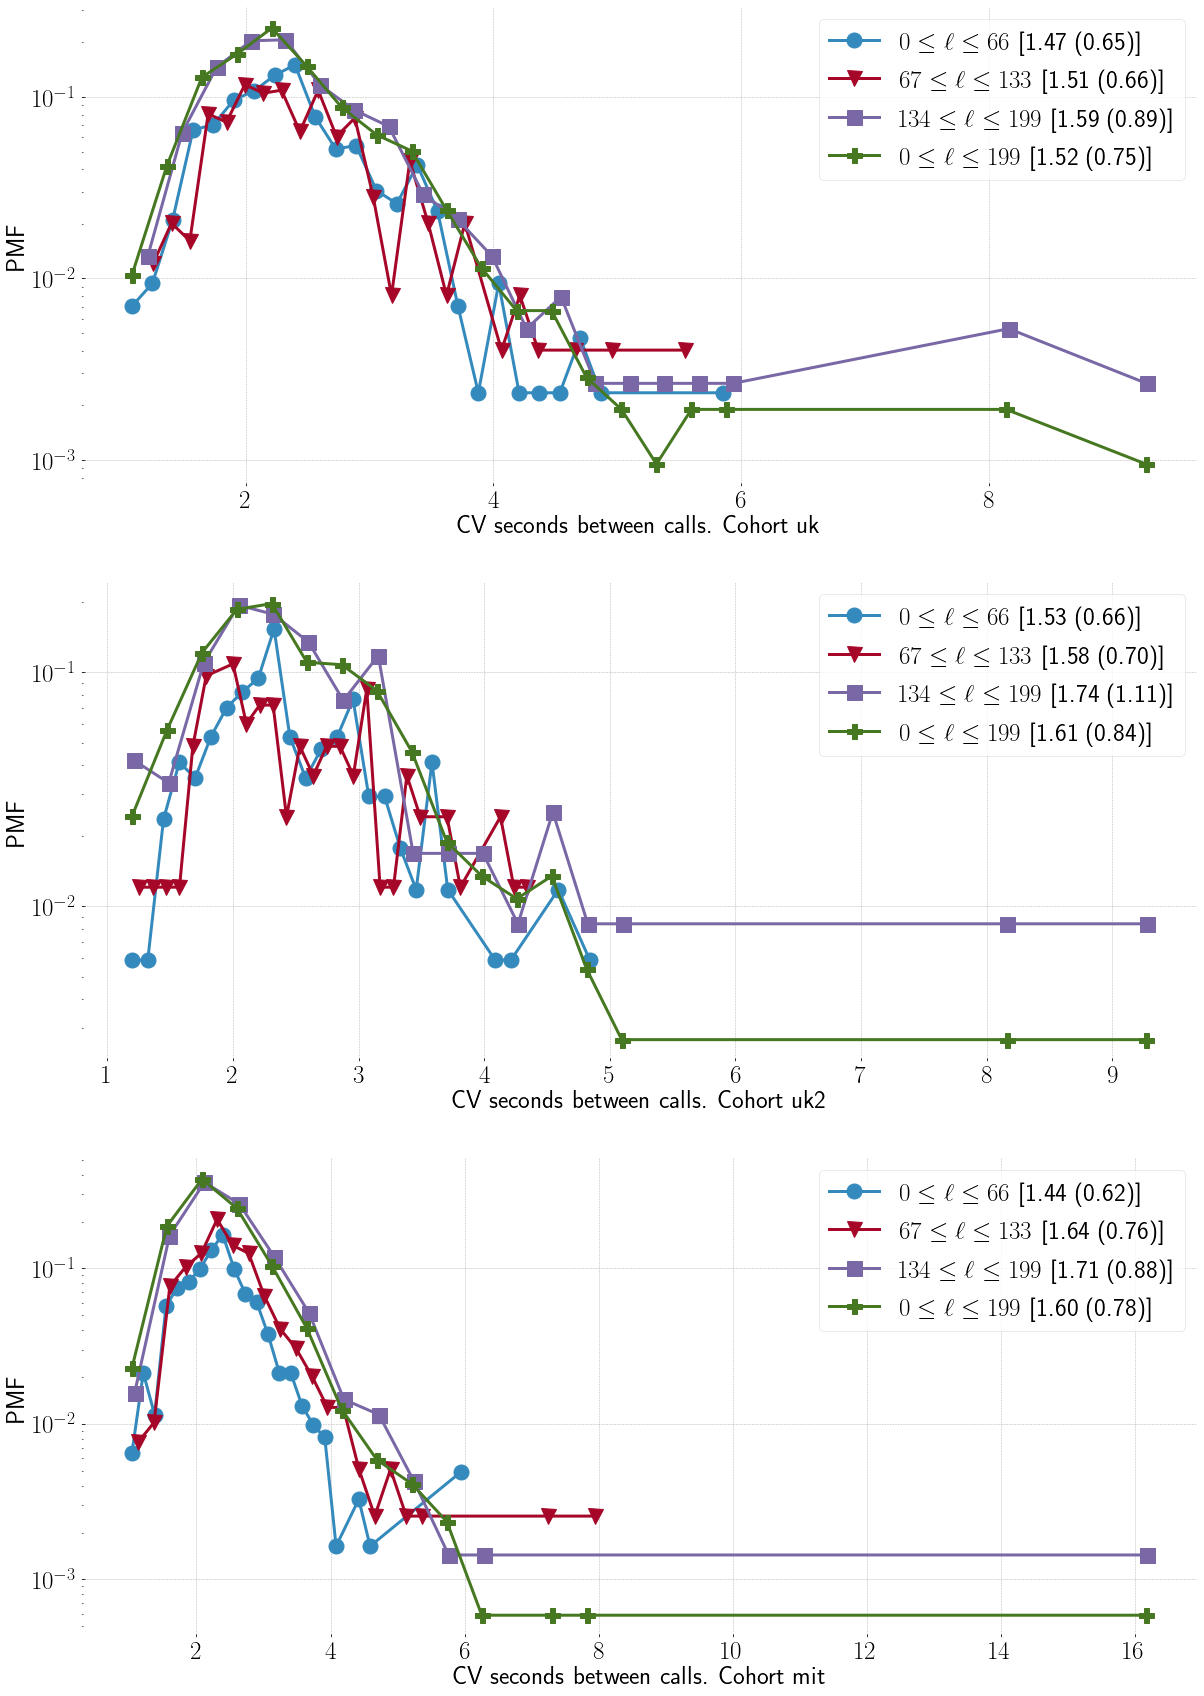

In [51]:
plt.figure(figsize=(20, 30))
p = 1
for c in ['uk', 'uk2', 'mit']:
    plt.subplot(3,1,p)
    plt.xlabel(f"CV seconds between calls. Cohort {c}")
    plt.ylabel("PMF")
#     plt.xlim(10**5, 10**8)
    plt.semilogy()
    m = 0
    for k in consec_bys[c].keys():
        plt.plot(consec_bys[c][k][1]['label'] + 1, consec_bys[c][k][1]['pmf'], marker=markers[m], ls="-", markersize=15, lw=3, 
                 label=fr'${limits[k][0]} \leq \ell \leq {limits[k][1]}$ [{consec_bys[c][k][2]:.2f} ({consec_bys[c][k][3]:.2f})]')
        m += 1
    plt.legend()
    p += 1

### Pick a day

In [62]:
hh = {}
for c in calls.keys():
    df = calls[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    ncalls = df.groupby('ea')[['time']].count()
    ncalls = ncalls.loc[ncalls['time'] > 2]
    df = df[df['ea'].isin(ncalls.index)]
    df['cal_day'] = df['time'].map(lambda x: x.date())
    hh[c] = {}
    hh[c]['calls'] = df.groupby('cal_day')[['aclock']].count().sort_index()
    hh[c]['calls']['calls'] = hh[c]['calls']['aclock'].div(sum(hh[c]['calls']['aclock']))
    hh[c]['pairs'] = df.groupby('cal_day')[['ea']].nunique()
    hh[c]['pairs']['pairs'] = hh[c]['pairs']['ea'].div(sum(hh[c]['pairs']['ea']))

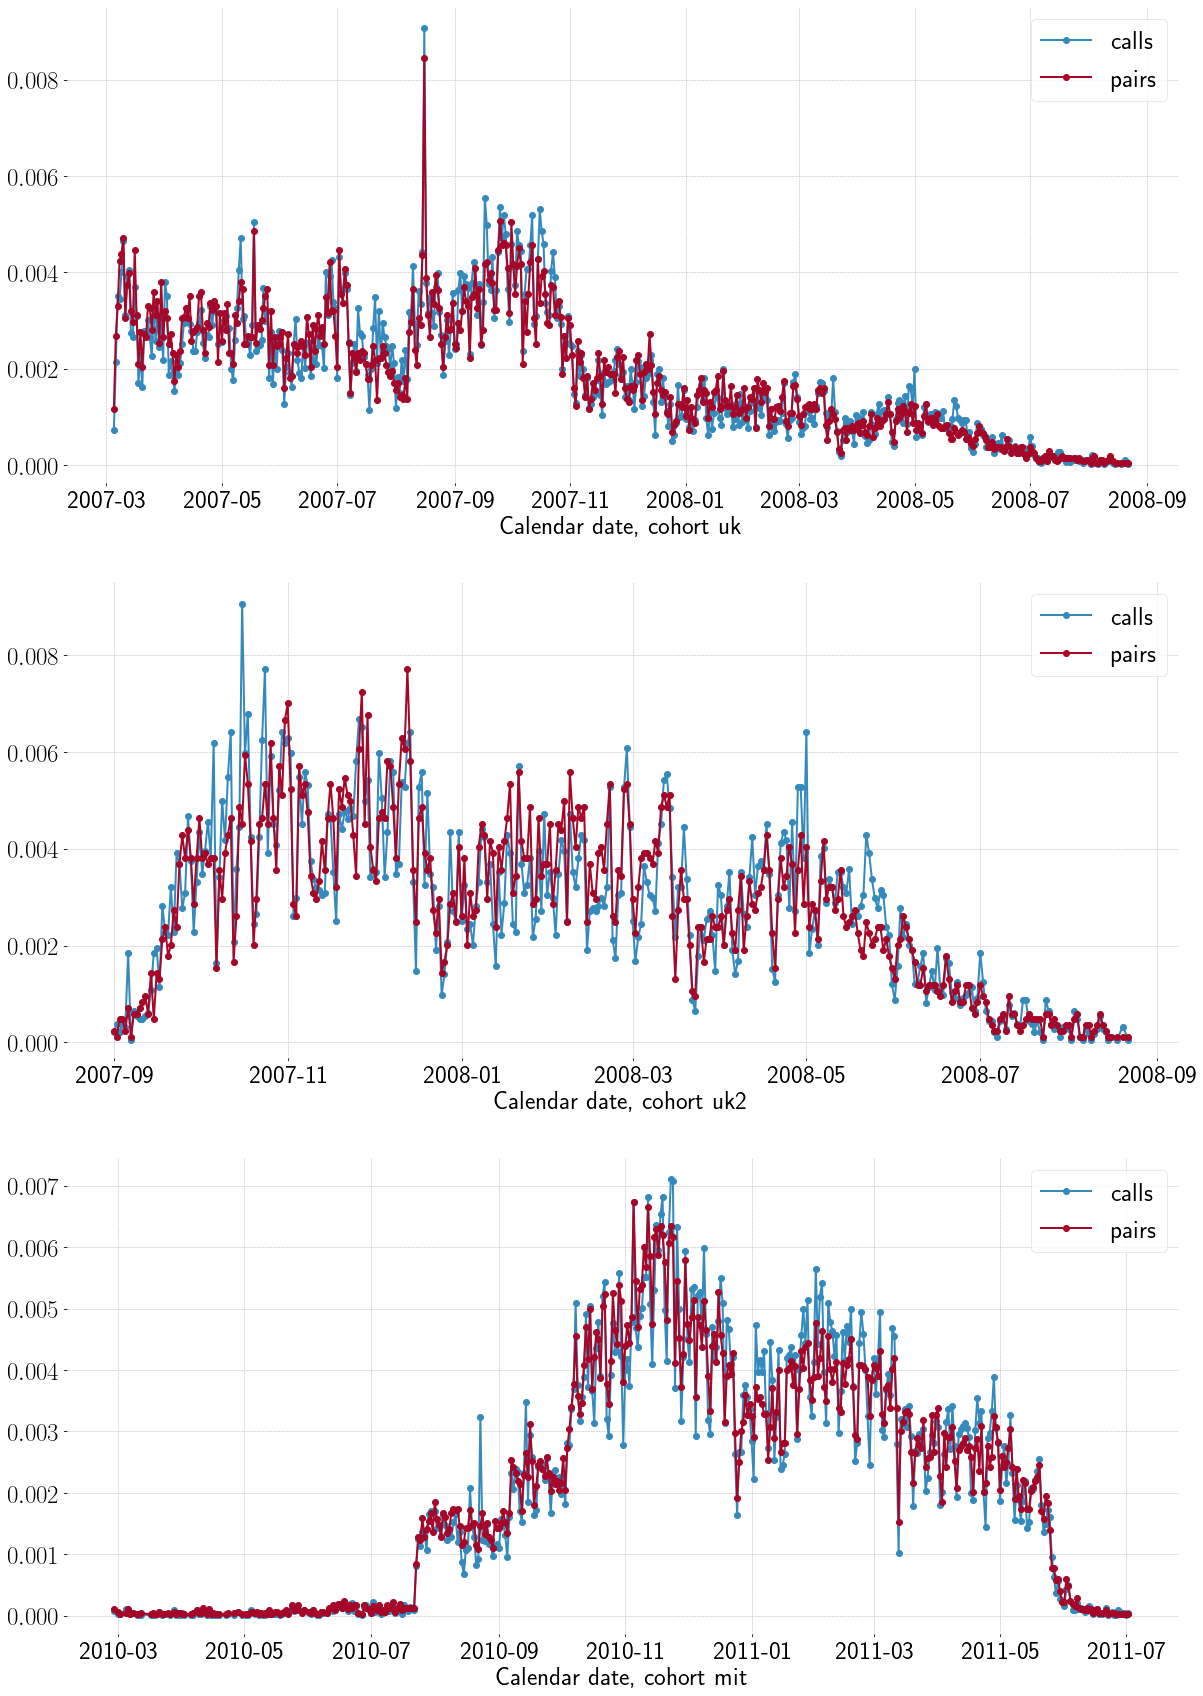

In [122]:
plt.figure(figsize=(20, 30))
p = 1
for c in hh.keys():
    plt.subplot(3, 1, p)
    plt.xlabel(f"Calendar date, cohort {c}")
#     if c == 'uk':
#         plt.xlim(dt.date(2007, 4, 1), dt.date(2007, 5, 31))
#     elif c == 'uk2':
#         plt.xlim(dt.date(2007, 10, 1), dt.date(2007, 11, 30))
#     else:
#         plt.xlim(dt.date(2010, 10, 1), dt.date(2010, 11, 30))
    for v in hh[c].keys():
        plt.plot(hh[c][v].index, hh[c][v][v], "o-", label=f'{v}')
    plt.legend()
    p += 1

In [89]:
days = {}
days['uk'] = (dt.datetime(2007, 4, 27, 17, 0), dt.datetime(2007, 4, 28, 16, 59))
days['uk2'] = (dt.datetime(2007, 10, 4, 17, 0), dt.datetime(2007, 10, 5, 16, 59))
days['mit'] = (dt.datetime(2010, 10, 21, 17, 0), dt.datetime(2010, 10, 22, 16, 59))

In [90]:
calls24h = {}
for c in calls.keys():
    df = calls[c].copy(deep=True)
    df = df.loc[(df['time'] >= days[c][0]) & (df['time'] <= days[c][1])]
    calls24h[c] = calls_by_second(df)

lost 122 pairs
lost 36 pairs
lost 239 pairs


In [91]:
oneday = {}
for c in calls24h.keys():
    oneday[c] = consecutive_bys(calls24h[c], 0, 200, nolives=calls[c])

In [92]:
for c in oneday.keys():
    print(f'{c}\nAccepted pairs:\t {oneday[c][4]}\nRejected pairs:\t {oneday[c][5]}')

uk
Accepted pairs:	 3
Rejected pairs:	 0
uk2
Accepted pairs:	 5
Rejected pairs:	 0
mit
Accepted pairs:	 15
Rejected pairs:	 0


In [93]:
for c in calls24h.keys():
    print(len(calls24h[c]))

70
43
384


In [80]:
oneday['uk'][0]

h   pmf    label
0   15  0.75      0.0
1    2  0.10   1838.0
4    1  0.05   7352.0
6    1  0.05  11028.0
29   1  0.05  53302.0

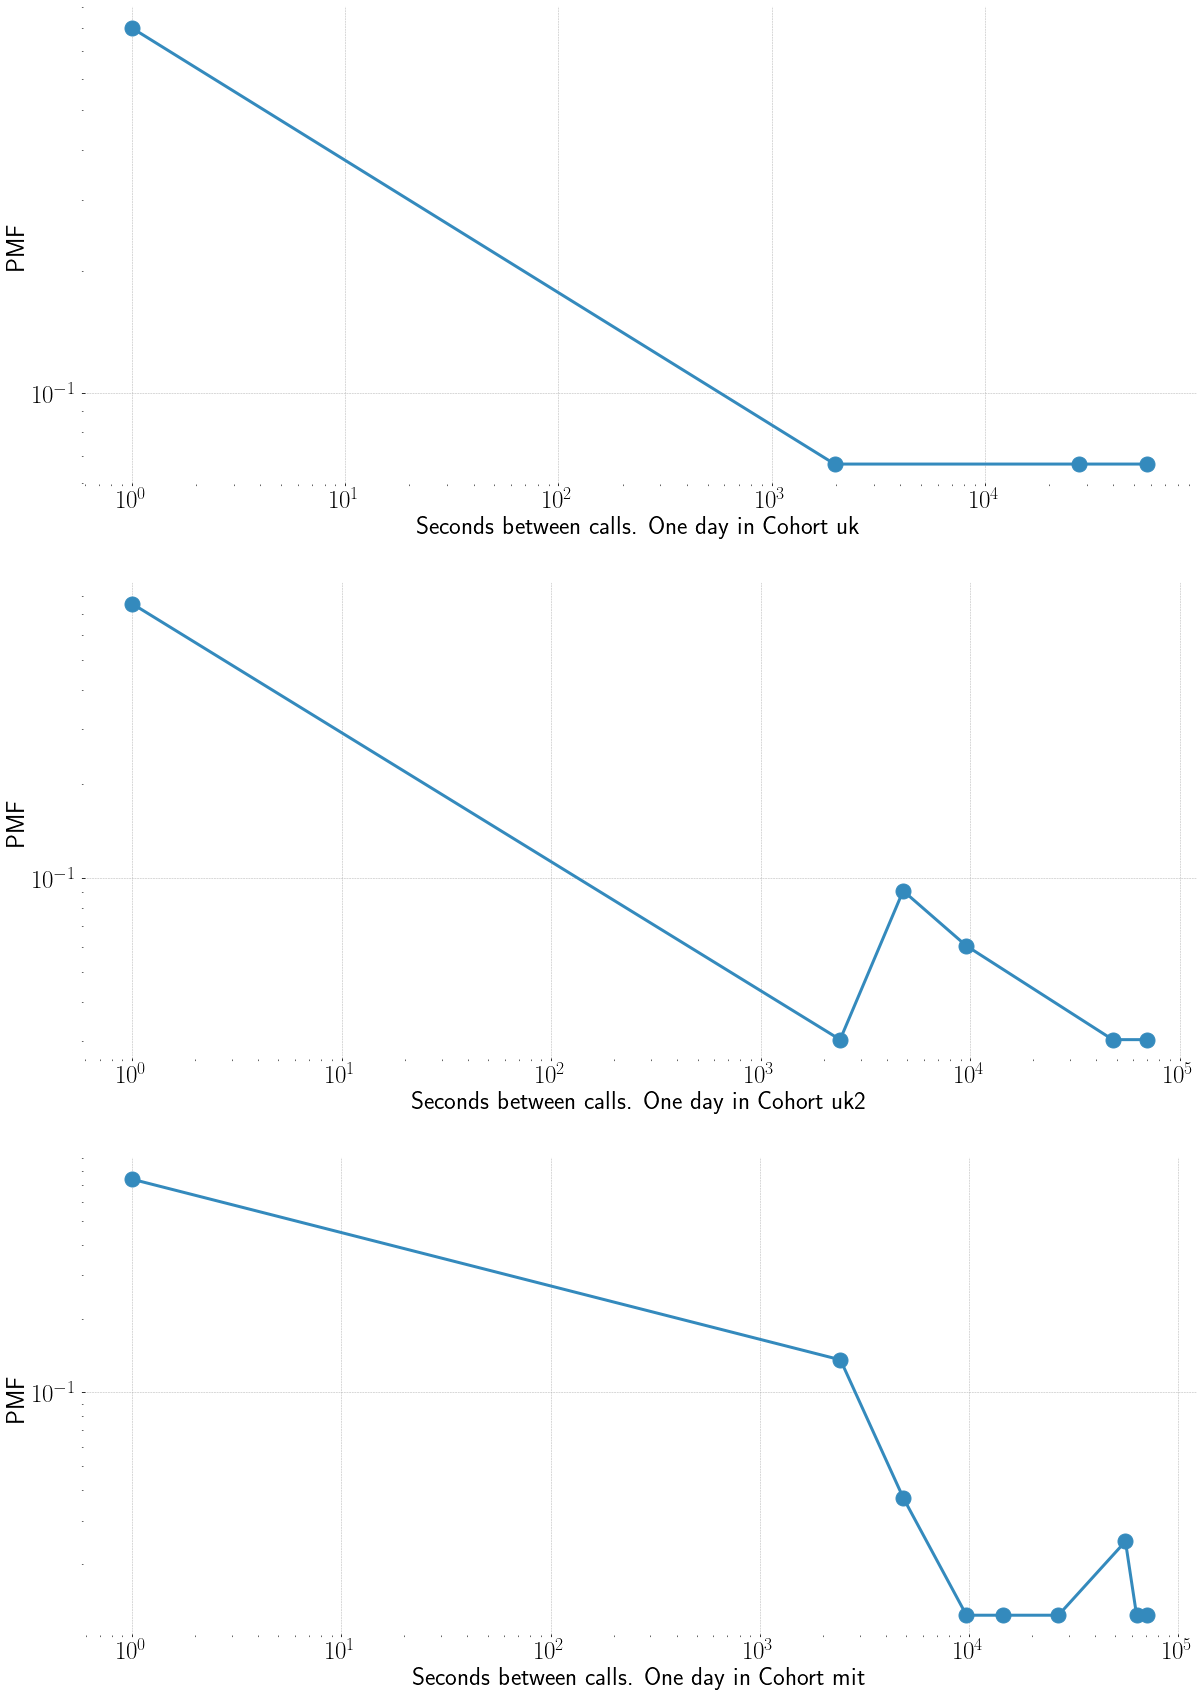

In [94]:
plt.figure(figsize=(20, 30))
p = 1
for c in ['uk', 'uk2', 'mit']:
    plt.subplot(3,1,p)
    plt.xlabel(f"Seconds between calls. One day in Cohort {c}")
    plt.ylabel("PMF")
    plt.loglog()
    plt.plot(oneday[c][0]['label'] + 1, oneday[c][0]['pmf'], "o-", markersize=15, lw=3)
    p += 1

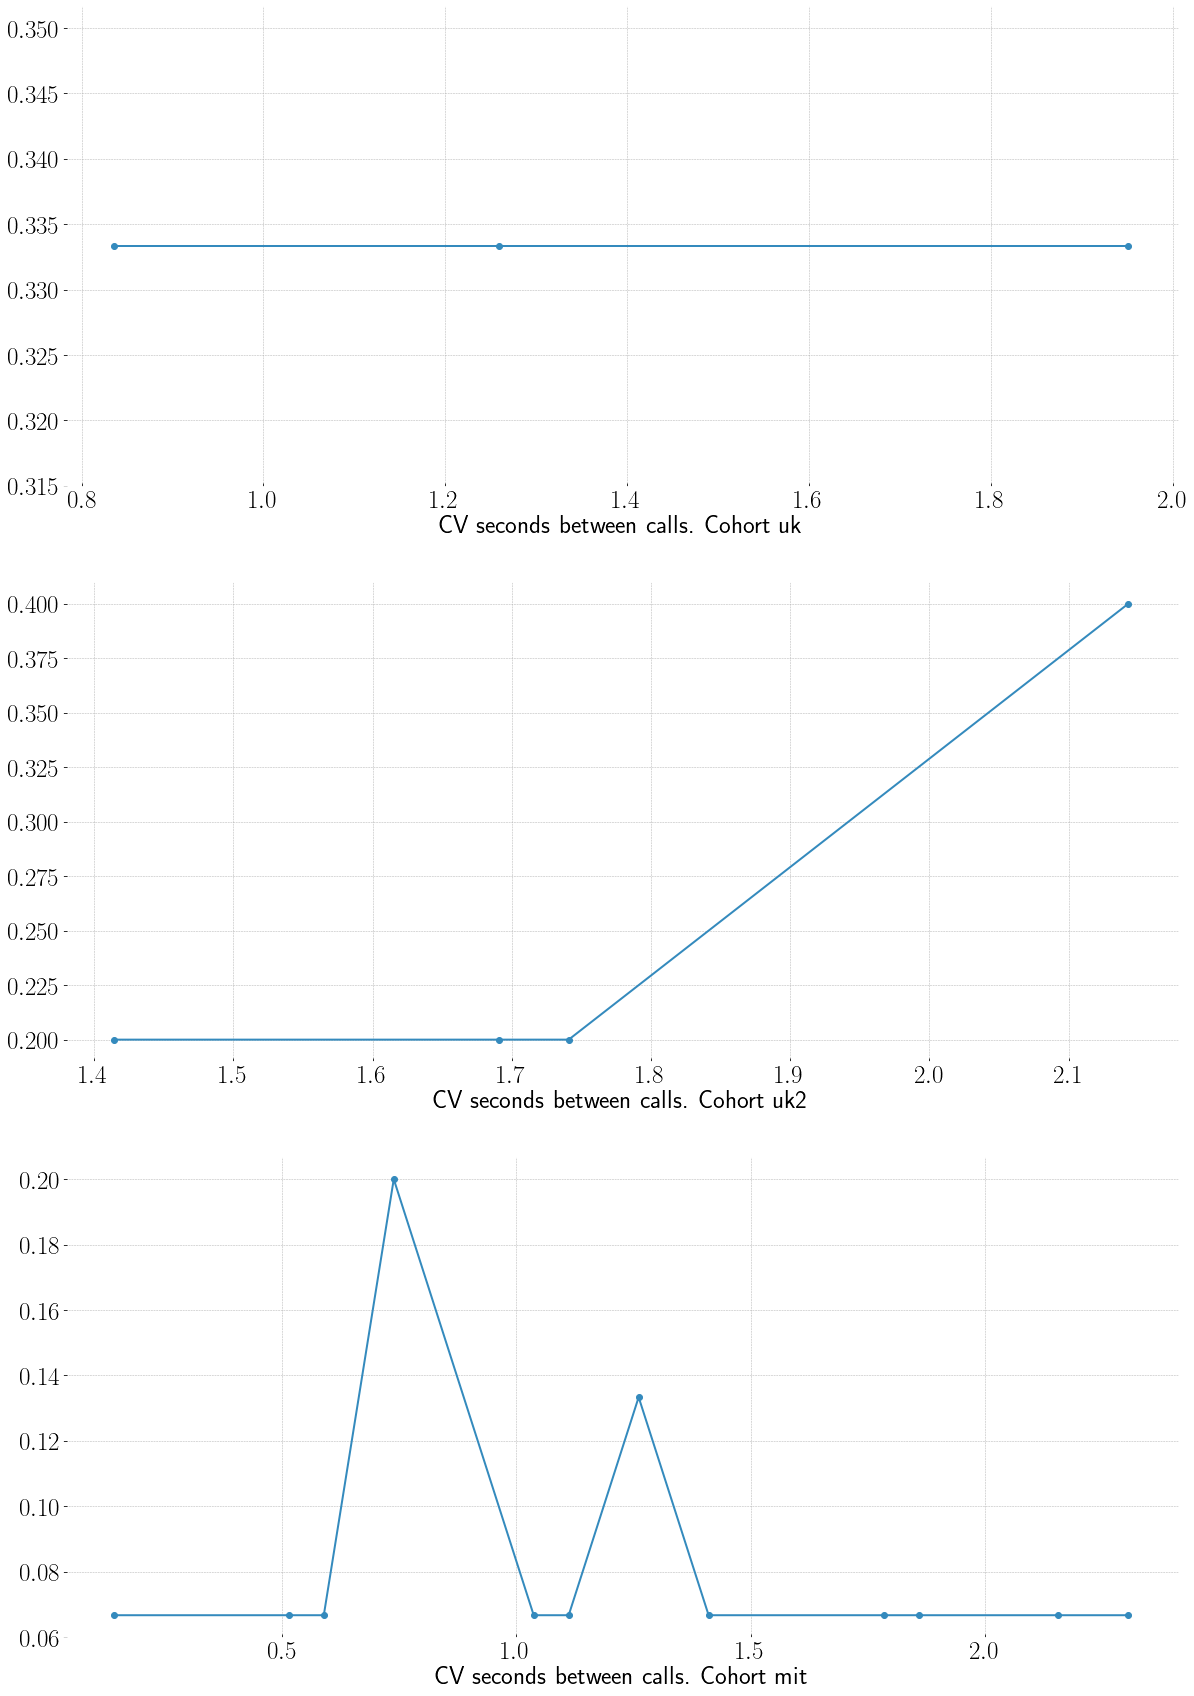

In [95]:
plt.figure(figsize=(20, 30))
p = 1
for c in oneday.keys():
    plt.subplot(3,1,p)
    plt.xlabel(f'CV seconds between calls. Cohort {c}')
    plt.plot(oneday[c][1]['label'], oneday[c][1]['pmf'], "o-")
    p += 1

In [141]:
a = ('articuno', 'jynx', 'nidorina')

In [142]:
with open('a.pickle', 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)
    handle.close()

In [143]:
with open('a.pickle', 'rb') as handle:
    b = pickle.load(handle)
    handle.close()

In [144]:
b

('articuno', 'jynx', 'nidorina')

In [ ]:
def get_ietimes(callsdf, maxell = 199, Deltaell = 67, daysres = 1):
    df = callsdf
    iebyego = {}
    ieegoalter = {}
    ieegoalter['all'] = []
    for ego in df['ego'].unique():
        df1 = df.loc[df['ego'] == ego]
        elllist = df1.groupby('alter')[['aclock']].max()
        iebyego[ego] = {}
        iebyego[ego]['all'] = []
        for alter in df1['alter'].unique():
            ell = elllist['aclock'][alter]
            if ell <= maxell:
                lamb = ell // Deltaell
                df2 = df1.loc[df1['alter'] == alter]
                df2 = df2.sort_values(by='time')
                df3 = df2.copy()
                df3['tmp'] = df2['aclock'] // daysres
                ielist = list(df3['tmp'].diff())[1:]
                ieegoalter[lamb] = ieegoalter.get(lamb, [])
                if (len(ielist) > 2) and (np.nanmean(ielist) != 0):
                    cvar = np.nanstd(ielist) / np.nanmean(ielist)
                    if not pd.isna(cvar):
                        ieegoalter[lamb].append(cvar)
                        ieegoalter['all'].append(cvar)
                        iebyego[ego][lamb] = iebyego[ego].get(lamb, [])
                        iebyego[ego][lamb].append(cvar)
                        iebyego[ego]['all'].append(cvar)
    result = {}
    result['byego'] = iebyego
    result['egoalter'] = {}
    for lamb in ieegoalter.keys():
        result['egoalter'][lamb] = ieegoalter[lamb]
    return result

In [ ]:
iedata = {}
for c in calls.keys():
    iedata[c] = {}
    for dr in [1,2,4,8,16]:
        iedata[c][dr] = get_ietimes(calls[c], daysres=dr)

In [ ]:
for c in iedata.keys():
    print(f'================{c}=============')
    for dr in iedata[c].keys():
        thelist = iedata[c][dr]['egoalter']['all']
        print(dr, np.mean(thelist), np.std(thelist))

In [ ]:
iedata['uk'][1].keys()

In [ ]:
ieH = {}
for c in iedata.keys():
    ieH[c] = {}
    for dr in iedata[c].keys():
        ieH[c][dr] = {}
        for k in [0,1,2,'all']:
            ieH[c][dr][k] = iedata[c][dr]['egoalter'][k]
ieH['all'] = {}
for dr in [1,2,4,8,16]:
    ieH['all'][dr] = {}
    for k in [0,1,2,'all']:
        for c in ['uk', 'mit']:
            ieH['all'][dr][k] = ieH['all'][dr].get(k, [])
            ieH['all'][dr][k] += ieH[c][dr][k]
            
for c in ieH.keys():
    for dr in ieH[c].keys():
        for k in ieH[c][dr].keys():
            ieH[c][dr][k] = (np.nanmean(ieH[c][dr][k]), pc.histogram(ieH[c][dr][k], 30, log=False), len(ieH[c][dr][k]))

In [ ]:
plt.figure(figsize=(36, 40))
labels = ['Short Lifetime', 'Middle Lifetime', 'Long Lifetime', 'All Lifetime']
p = 1
for dr in [1,2,4,8,16]:
    for c in ['uk', 'mit', 'all']:    
        plt.subplot(5,3,p)
        plt.xlabel(f"CV {c}. Resolution {dr} days")
        plt.ylabel("PMF")
        plt.xlim(-0.2, 15.3)
        lab = 0
        for k in [0, 1, 2, 'all']:
            plt.plot(ieH[c][dr][k][1]['label'], ieH[c][dr][k][1]['pmf'], marker=markers[lab], markersize=13, ls="--", label=f'{labels[lab]} ({ieH[c][dr][k][0]:.2f}) n = {ieH[c][dr][k][2]}')
            lab += 1
        plt.legend()
        p += 1

# Global Time

In [ ]:
globaltf = dt.datetime.now() - globalt0
print(f'This notebook took {globaltf}')
os.system(f"notify-send 'Notebook done' 'it took {globaltf}'")